# 毕设说明书
---

## 地图匹配，将充电需求对应在路网图中

1.将充电需求对应在路网图中，路网图为二维平面，充电需求由车辆产生，根据充电需求产生的地址将其对应到路网图中的点，所述点称为需求点。
所述需求点从城市中车辆停留时间较长的位置产生，包括以下信息：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程。

In [ ]:
'''
#1 —— 一次性执行
#t —— 测试单元，可删除
'''

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from scipy.stats import truncnorm
import math
import pickle
import re
from random import choice
from concurrent.futures import ProcessPoolExecutor as Pool
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 
data_dir = 'data-QGA'

随机地图数据（包括地图块类型：小区、办公区、商贸区），地图设置为$1000\times1000$大小，其中住宅区占比：30%，办公区占比：10%,商贸区占比：5%

0-没有需求区域，1-小区，2-办公区，3-商贸区

In [3]:
# 常量定义
map_size = 100 #地图大小
map_step = 20  #划分地图

In [4]:
#1 使用随机直线划分格子
while True:
    map_roll = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
    map_cul = np.sort(np.unique(np.random.randint(1, map_size, map_step-1)))#划分地图区域
    if len(map_cul)==19 and len(map_roll)==19:
        break
print(map_roll.size)
print(map_cul.size)

19
19


In [5]:
#1 写入文件 
np.savetxt(data_dir+'/map_roll.txt', map_roll, fmt='%d', delimiter=',')
np.savetxt(data_dir+'/map_cul.txt', map_cul, fmt='%d', delimiter=',')

In [6]:
# 从文件中读取
map_roll = np.loadtxt(data_dir+'/map_roll.txt', delimiter=',', dtype=int)
map_roll = np.append(map_roll, map_size)
#map_roll = np.insert(map_roll, 0, 0)
map_cul = np.loadtxt(data_dir+'/map_cul.txt', delimiter=',', dtype=int)
#map_cul = np.insert(map_cul, 0, 0)
map_cul = np.append(map_cul, map_size)

In [7]:
#t
print(map_cul)

[  8  11  12  13  16  17  34  35  43  48  49  50  53  54  57  70  73  79
  98 100]


In [8]:
#1 随机区域
map_rate = [0.55, 0.3, 0.1, 0.05]
map_x = np.arange(4)
map_distribution = np.random.choice(a=map_x, size=map_step**2, replace=True, p=map_rate)

In [9]:
#1 将区域信息写入文件
np.savetxt(data_dir+'/map_distribution.txt', map_distribution, fmt='%d', delimiter=',')

In [10]:
# 读取区域
map_distribution = np.loadtxt(data_dir+'/map_distribution.txt', delimiter=',', dtype=int)

In [11]:
#t 看比例
print(sum(map_distribution==0)/map_step**2)
print(sum(map_distribution==1)/map_step**2)
print(sum(map_distribution==2)/map_step**2)
print(sum(map_distribution==3)/map_step**2)

0.5675
0.3
0.0675
0.065


In [12]:
#1 将地图赋值     

mmap = np.ones((map_size,map_size), dtype=np.int) #地图

x_b = 0
y_b = 0
it_mapd = 0
for y_e in map_cul:
    for x_e in map_roll:
        mmap[x_b:x_e, y_b:y_e] *= map_distribution[it_mapd]
        x_b = x_e
        it_mapd += 1
    y_b = y_e

In [13]:
#1 将地图存入文件
np.savetxt(data_dir+'/mmap.txt', mmap, fmt='%d', delimiter=',')

In [14]:
# 读取地图
mmap = np.loadtxt(data_dir+'/mmap.txt', delimiter=',', dtype=int)

In [15]:
#t 查看每种区域的地图占比
print(sum(sum(mmap==0))/map_size**2)
print(sum(sum(mmap==1))/map_size**2)
print(sum(sum(mmap==2))/map_size**2)
print(sum(sum(mmap==3))/map_size**2)

0.5445
0.3302
0.0567
0.0686


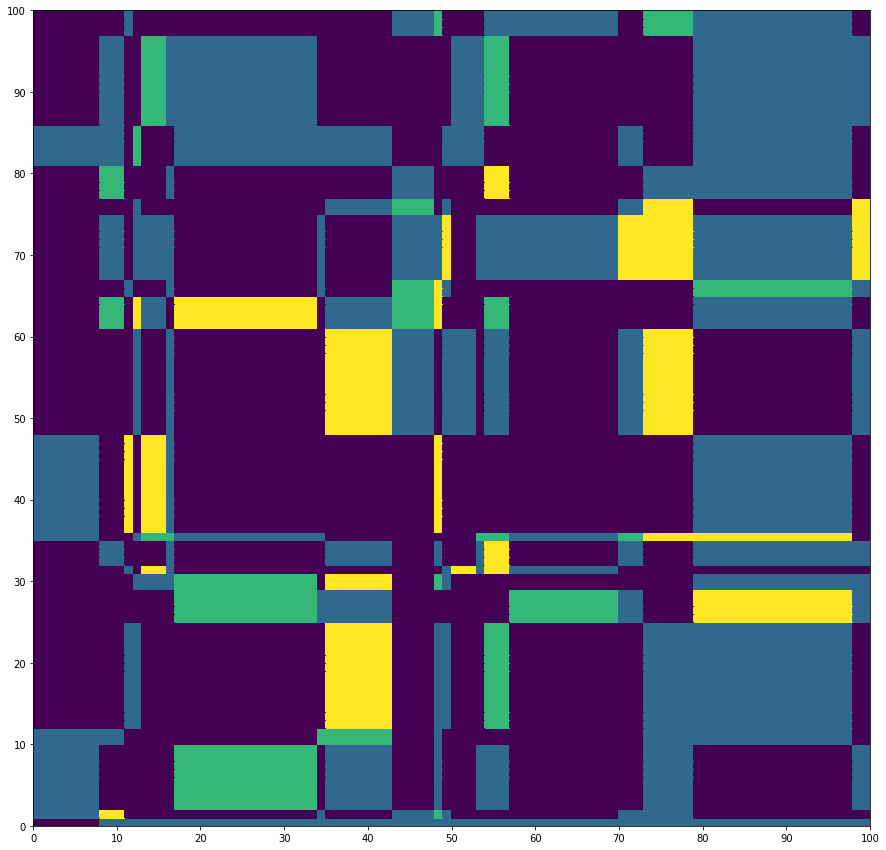

In [16]:
#t 将地图画出来
'''
0-其他区域-深深绿
1-住宅区-深绿
2-办公区-绿色
3-商贸区-黄色
'''
plt.figure(figsize=(15,15))
plt.pcolormesh(mmap,edgecolors='face')
#把x轴的刻度间隔设置为1，并存在变量里
x_major_locator=MultipleLocator(10)
#把y轴的刻度间隔设置为10，并存在变量里
y_major_locator=MultipleLocator(10)
#ax为两条坐标轴的实例
ax=plt.gca()
#把x轴的主刻度设置为50的倍数
ax.xaxis.set_major_locator(x_major_locator)
#把y轴的主刻度设置为50的倍数
ax.yaxis.set_major_locator(y_major_locator)
plt.show()

随机车辆，地图类型对需求产生的时间要求：
1. 住宅区：车辆需求点产生时间多半在中午和夜晚，时间17:00-21:00~7:00-9:00和11:00-12:00~13:30-14:00
2. 办公区：车辆需求点产生时间多半在上午和下午，时间7:00-9:00~11:00-12:00和13:30-14:00~17:00-21:00
3. 商贸区：时间8:00~21:00，时间段多数在2小时以上
4. 其他区域：时间不固定

随机的变量：充电需求产生的地址、充电需求产生的时间、预估的充电时长和车辆剩余行驶里程

随机车辆4000，其中2500遵循上班时间，1000遵循购物娱乐时间，500遵循在家时间

In [17]:
#1 随机时间
'''
car_cate
0-上班时间
时间：住宅区+办公区
地点：住宅+办公

1-娱乐时间
时间：住宅区+商贸区
地点：住宅+商贸

2-在家时间
时间：全天
地点：住宅
'''
#截断正态分布函数
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

car_num_0 = 2500
car_num_1 = 1000
car_num_2 = 500

# 上班时间
def cars_0():
    # 随机时间
    time_point_1_normal = get_truncated_normal(8.5, 1.5, 5, 10)
    time_point_1 = time_point_1_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_2_normal = get_truncated_normal(11.5, 0.5, 11, 12)
    time_point_2 = time_point_2_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_3_normal = get_truncated_normal(14, 0.5, 13, 15)
    time_point_3 = time_point_3_normal.rvs(car_num_0).reshape(car_num_0, 1)
    time_point_4_normal = get_truncated_normal(19, 1.5, 17, 21)
    time_point_4 = time_point_4_normal.rvs(car_num_0).reshape(car_num_0, 1)
    # 车辆id，为列向量
    car_id = np.arange(0,car_num_0).reshape(car_num_0, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_0, replace=True)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_2_index = np.random.choice(a=np.argwhere(mmap==2).shape[0], size=car_num_0, replace=True)#办公地址
    addr_2 = [np.argwhere(mmap==2)[i] for i in addr_2_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_0*4).reshape(car_num_0*4,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    
    car_id_con = np.concatenate((np.concatenate((car_id, car_id)), 
                                 np.concatenate((car_id, car_id))))
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), 
                                     np.concatenate((time_point_3, time_point_4))))
    addr_con = np.concatenate((np.concatenate((addr_2, addr_1)),
                               np.concatenate((addr_2, addr_1))))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_0_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_0_request = np.concatenate((car_0_request, remain_licheng), axis=1)
    # np.savetxt('data/car_0_request_test.txt', car_0_request, fmt='%f', delimiter=',')  
    df_car_0_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_0_request_read['充电需求产生的时间'] = time_point_con
    df_car_0_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request_read['预估充电时长'] = charge_time
    df_car_0_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_0_request_read.to_csv(data_dir+'/df_car_0_request_read.csv')
    
    df_car_0_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_0_request['time_point'] = time_point_con
    df_car_0_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_0_request['charge_time'] = charge_time
    df_car_0_request['remain_licheng'] = remain_licheng
    df_car_0_request.to_csv(data_dir+'/df_car_0_request.csv')
    return df_car_0_request

# 娱乐时间
def cars_1():
    # 随机时间
    time_point_1_normal = get_truncated_normal(11, 1, 9, 13) # 去商场的时间点1
    time_point_1 = time_point_1_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_point_2_normal = get_truncated_normal(15, 2, 13, 19) # 去商场的时间点2
    time_point_2 = time_point_2_normal.rvs(int(car_num_1/2)).reshape(int(car_num_1/2), 1)
    time_last_normal = get_truncated_normal(4, 1.5, 2, 11)
    time_last = time_last_normal.rvs(car_num_1).reshape(car_num_1, 1)
    time_point_temp = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_last), axis=1)
    time_point_3 = np.zeros((car_num_1, 1))  #回住宅的时间
    tp_i = 0
    for tpt in time_point_temp: # 24小时制
        time_p = tpt[0]+tpt[1]
        if time_p > 24:
            time_p -= 24
        time_point_3[tp_i] = time_p
        tp_i += 1
    time_point_con = np.concatenate((np.concatenate((time_point_1, time_point_2)), time_point_3))
    # 车辆id，为列向量
    car_id = np.arange(car_num_0, car_num_0+car_num_1).reshape(car_num_1, 1)
    # 随机地址
    addr_1_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_1, replace=False)#住宅地址
    addr_1 = [np.argwhere(mmap==1)[i] for i in addr_1_index]
    addr_3_index = np.random.choice(a=np.argwhere(mmap==3).shape[0], size=car_num_1, replace=True)#商贸地址
    addr_3 = [np.argwhere(mmap==3)[i] for i in addr_3_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_1*2).reshape(car_num_1*2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    car_id_con = np.concatenate((car_id, car_id))
    addr_con = np.concatenate((addr_3, addr_1))
    df_addr_con = pd.DataFrame(addr_con, columns = ['x','y'])
    #car_1_request = np.concatenate((np.concatenate((car_id_con, time_point_con), axis=1), 
    #                                np.concatenate((addr_con, charge_time), axis=1)), axis=1)
    #car_1_request = np.concatenate((car_1_request, remain_licheng), axis=1)
    # np.savetxt('data/car_1_request.txt', car_1_request, fmt='%f', delimiter=',')
    df_car_1_request_read = pd.DataFrame(car_id_con, columns = ['车辆id'])
    df_car_1_request_read['充电需求产生的时间'] = time_point_con
    df_car_1_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request_read['预估充电时长'] = charge_time
    df_car_1_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_1_request_read.to_csv(data_dir+'/df_car_1_request_read.csv')
    
    df_car_1_request = pd.DataFrame(car_id_con, columns = ['car_id'])
    df_car_1_request['time_point'] = time_point_con
    df_car_1_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_1_request['charge_time'] = charge_time
    df_car_1_request['remain_licheng'] = remain_licheng
    df_car_1_request.to_csv(data_dir+'/df_car_1_request.csv')
    return df_car_1_request


# 在家时间
def cars_2():
    # 随机时间
    time_point_normal = get_truncated_normal(12, 10, 0, 24)
    time_point = time_point_normal.rvs(car_num_2).reshape(car_num_2, 1)
    # 车辆id，为列向量
    car_id = np.arange(car_num_0+car_num_1,car_num_0+car_num_1+car_num_2).reshape(car_num_2, 1)
    # 随机地址
    addr_index = np.random.choice(a=np.argwhere(mmap==1).shape[0], size=car_num_2, replace=True)#住宅地址
    addr = [np.argwhere(mmap==1)[i] for i in addr_index]
    # 随机充电时长和剩余行驶里程(充电时长最长为3h, 行驶里程最长为500km)
    charge_time_normal = get_truncated_normal(1.5, 0.5, 0, 3)
    charge_time = charge_time_normal.rvs(car_num_2).reshape(car_num_2,1)
    remain_licheng = (3-charge_time)/3*500
    # 形成车辆需求
    df_addr_con = pd.DataFrame(addr, columns = ['x','y'])
    df_car_2_request_read = pd.DataFrame(car_id, columns = ['车辆id'])
    df_car_2_request_read['充电需求产生的时间'] = time_point
    df_car_2_request_read['充电需求产生的地址'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request_read['预估充电时长'] = charge_time
    df_car_2_request_read['车辆剩余行驶里程'] = remain_licheng
    df_car_2_request_read.to_csv(data_dir+'/df_car_2_request_read.csv')
    
    df_car_2_request = pd.DataFrame(car_id, columns = ['car_id'])
    df_car_2_request['time_point'] = time_point
    df_car_2_request['addr'] = df_addr_con.apply(lambda r: tuple(r), axis=1).apply(np.array)
    df_car_2_request['charge_time'] = charge_time
    df_car_2_request['remain_licheng'] = remain_licheng
    df_car_2_request.to_csv(data_dir+'/df_car_2_request.csv')
    return df_car_2_request

In [18]:
#1 写入文件
df_car_request = cars_0().append(cars_1()).append(cars_2())
df_car_request.to_csv(data_dir+'/df_car_request.csv')

In [3]:
# 读取充电需求数据
df_car_request = pd.read_csv(data_dir+'/df_car_request.csv', engine='python')
df_car_request.drop(df_car_request.columns[0], axis=1, inplace=True) # 删除第一列

## 预测城市充电需求，确定充电热区

该步骤是使用基于区域充电需求量的聚类算法实现的，具体步骤如下：
1. 数据清洗，由于会出现多个充电需求对应到同一需求点的情况，需要统计每个充电需求中预估的充电时长，之后计算每个需求点的总预估的充电时长作为该需求点的需求分数，公式如下：
$$SC_p=\sum_{i=1}^{n}ST_i$$
其中$SC_p$表示需求点$p$的需求分数，$ST_i$表示对应到需求点$p$的第$i$个充电需求中的预估充电时长
2. 删除需求分数过低的需求点，根据预先设置的阈值，删除需求分数低于阈值的需求点；
3. 使用K-means算法将需求点进行聚类，得到不同密度的簇，即充电热区，其代表着有一定充电需求的区域。

其中，步骤3中聚类个数K使用肘部法则来确定，将各个簇内的样本点到所在簇质心的距离平方和（SSE）作为性能度量，越小则说明各个类簇越收敛。但不是SSE越小越好，肘部法则就是在类簇数量与SSE之间寻求一个平衡点，具体步骤如下：

(1)指定一个i值，即可能的最大类簇数；

(2) 然后将类簇数从1开始递增，一直到$i$，计算出$i$个$SSE$，公式如下：
$$SSE=\sum_{k=1}^{k}\sum_{i\epsilon C_k}^{i}\lvert x_i-\mu k \rvert$$
其中，$\mu k$是第k个质心的位置

(3)通过画出K-SSE曲线，找出下降途中的拐点，即可较好的确定K值。

In [20]:
#1 1.数据清洗
def str_to_np(str_attr): #将字符串转换为numpy数组
    str_temp = str_attr[1:-1].strip().split(' ')
    if len(str_temp) > 2:
        str_temp[1] = str_temp[2]
        del str_temp[2]
    str_temp[0] = int(str_temp[0])
    str_temp[1] = int(str_temp[1])
    str_temp = np.asarray(str_temp)
    return str_temp

P_set = set(df_car_request['addr']) #需求点集合(dtype='object')
P_np = np.asarray([str_to_np(dfp) for dfp in P_set]) #需求点集合(dtype='np.array')
SCP_np = np.zeros(len(P_set)) # 需求点对应的需求分数
car_sum_np = np.zeros(len(P_set)) # 需求点对应的平均充电时间
it_scp = 0 #迭代数
for p in P_set: #计算需求分数
    it_df_p = df_car_request[df_car_request['addr'] == p]
    scp = it_df_p['charge_time'].sum()
    SCP_np[it_scp] = scp
    car_sum_np[it_scp] = len(it_df_p['charge_time'])
    it_scp += 1
    
df_p_np = pd.DataFrame(P_np, columns = ['x','y'])

df_scp = pd.DataFrame(df_p_np.apply(lambda r: tuple(r), axis=1).apply(np.array), columns=['addr'])
SCP_np.reshape(len(P_set), 1)
df_scp['scp'] = SCP_np
df_scp['car_sum'] = car_sum_np

# 2.删除需求分数过低的需求点（小于1的）
del_labels = np.where(SCP_np < 3)
del_labels = del_labels[0]
df_scp = df_scp.drop(del_labels)
# 将需求存入文件
df_scp.to_csv(data_dir+'/df_scp.csv') 

In [21]:
#t
print('需求分数小于1.5的占比：'+str(sum(SCP_np < 1.5)*100/len(SCP_np))+'%')
print('需求分数小于2.5的占比：'+str(sum(SCP_np < 2.5)*100/len(SCP_np))+'%')
print('需求分数小于3的占比：'+str(sum(SCP_np < 3)*100/len(SCP_np))+'%')
print('需求分数小于4的占比：'+str(sum(SCP_np < 4)*100/len(SCP_np))+'%')
print('需求分数小于5的占比：'+str(sum(SCP_np < 5)*100/len(SCP_np))+'%')

需求分数小于1.5的占比：11.912316123449669%
需求分数小于2.5的占比：28.872223824632247%
需求分数小于3的占比：37.00605710989328%
需求分数小于4的占比：52.61032593019902%
需求分数小于5的占比：62.070954715892704%


In [4]:
# 读取df_scp
def str_to_np(df_scp_0): #将df_scp中地址转换为numpy数组
    scp_0_array = np.zeros((len(df_scp_0), 2))
    it = 0
    for df_0 in df_scp_0:
        str_temp = df_0[1:-1].strip().split(' ')
        if len(str_temp) > 2:
            str_temp[1] = str_temp[2]
            del str_temp[2]
        str_temp[0] = int(str_temp[0])
        str_temp[1] = int(str_temp[1])
        scp_0_array[it] = [str_temp[0], str_temp[1]]
        it += 1
    return scp_0_array

df_scp = pd.read_csv(data_dir+'/df_scp.csv', engine='python')
df_scp.drop(df_scp.columns[0], axis=1, inplace=True) # 删除第一列
np_df_scp_addr = str_to_np(df_scp['addr']) # 需求点地址numpy数组
np_df_scp_scp = np.asarray(df_scp['scp']) # 需求点分数的numpy数组
np_df_scp_car_sum = np.asarray(df_scp['car_sum']) # 需求点车辆总数

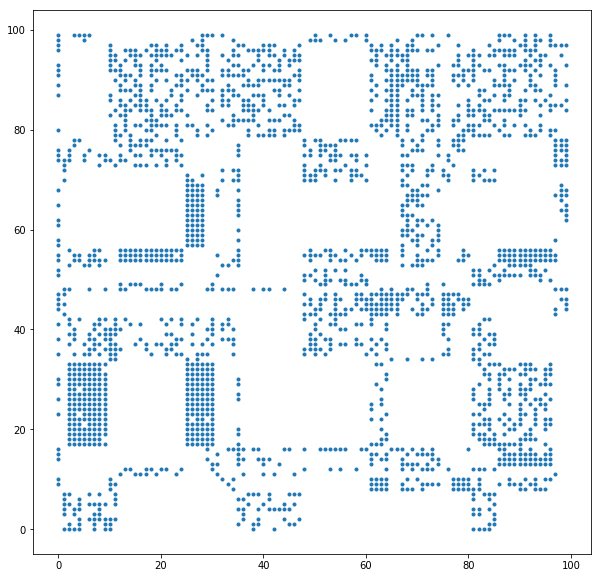

In [23]:
#t 需求点分布
plt.figure(figsize=(10,10))
plt.plot([x[0] for x in np_df_scp_addr], [x[1] for x in np_df_scp_addr], '.')
plt.show()

In [5]:
# 聚类定义
# np_df_scp_addr np_df_scp_scp

# 计算每个点到聚类中心的距离，并存入np_df_scp_centroids，即每个需求点对应的聚类中心
def assign(addr_attr, centroids):
    centroids_attr = np.zeros((len(addr_attr), 2))
    it_ndsc = 0
    for addr in addr_attr:
        distence = np.sqrt(np.sum(np.square(addr-centroids), axis=1))
        centroids_attr[it_ndsc] = centroids[np.argmin(distence)]
        it_ndsc += 1
    return centroids_attr


# 计算某聚类中心和所有需求点的距离之和
def cal_dis(addr_attr, centroid_attr):
    distence_1 = np.sum(np.sqrt(np.sum(np.square(addr_attr-centroid_attr), axis=1)))
    return distence_1
                            
# 聚类
def clustering(num_cluster):
    #随机从需求点中选取num_cluster个初始聚类中心
    cluster_centroids_index = np.random.choice(a=np.arange(len(np_df_scp_addr)), size=num_cluster, replace=False)
    cluster_centroids = np.asarray([np_df_scp_addr[i] for i in cluster_centroids_index])
    #print(cluster_centroids)
    cluster_rounds = 0 # 聚类次数
    sse = 0 # 不平衡度
    while cluster_rounds < 50:
        sse = 0
        np_df_scp_centroids = assign(np_df_scp_addr, cluster_centroids) # 计算每个点的聚类中心
        # 更新聚类中心
        new_cluster_centroids = np.zeros((num_cluster, 2))
        it_ncc = 0
        for centroid in cluster_centroids:
            # 取出属于同一聚类中心的点的索引
            index = []
            for i in range(len(np_df_scp_centroids)):
                if np_df_scp_centroids[i][0] == centroid[0] and np_df_scp_centroids[i][1] == centroid[1]:
                    index.append(i)
            addr_temp = np.zeros((len(index), 2))# 簇集合
            it_at = 0
            for i in index:
                addr_temp[it_at] = np_df_scp_addr[i]
                it_at += 1
            addr_temp = np.asarray(addr_temp)
            sse += cal_dis(addr_temp, centroid)# 计算不平衡度
            new_cluster_centroids[it_ncc] = np.mean(addr_temp, axis=0)
            it_ncc += 1
        cluster_centroids = np.asarray(new_cluster_centroids)
        cluster_rounds += 1
    np.savetxt(data_dir+'/cluster_cen/cluster_centroids_'+str(num_cluster)+'.txt', cluster_centroids)
    return sse

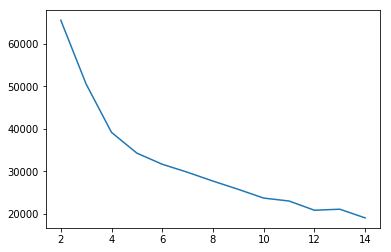

In [25]:
def sse():
    sse = []
    for k in range(2, 15):
        sse.append(clustering(k))
    return sse

x = np.arange(2, 15)

plt.plot(x, sse())
plt.show()

## 调整充电热区，确定充电站候选区域

总体方法为融合较小的簇、分割较大的簇，具体步骤如下：
1. 计算充电热区的半径和充电热区之间的距离矩阵；
2. 若某一充电热区和其他充电热区的距离小于r，则以半径r合并充电热区，其中r与电动汽车充满电的续航里程相关，r是为了保证电动汽车的剩余电量可以支撑其行驶到充电站，根据历史数据中电动汽车在该区域的平均剩余电量，可以利用现有方法估算行驶里程l，则$r=l$
3. 若充电热区的半径大于阈值r则在该热区内再次运行K-means算法划分新的充电热区，重复步骤1；
4. 得到充电站候选区域集合。

In [5]:
# 取出聚类中心
f_cluster_centroids = np.loadtxt(data_dir+'/cluster_cen/cluster_centroids_5.txt')
f_cluster_centroids

array([[20.37037037, 39.51010101],
       [77.8125    , 20.30803571],
       [52.41891892, 68.66409266],
       [85.61805556, 84.40972222],
       [13.43843844, 81.98798799]])

In [6]:
# 计算充电热区半径

# 计算距离 (多对一)
def cal_dis_2(addr_attr, centroid_attr):
    distence = np.sqrt(np.sum(np.square(addr_attr-centroid_attr), axis=1))
    return distence

# 计算充电热区之间的距离矩阵
def cal_dis_cen(centroids):
    dis = []
    for cen in centroids:
        distence = cal_dis_2(centroids, cen)
        distence.reshape(1, len(centroids))
        dis.append(distence)
    dis = np.asarray(dis)
    return dis

# 获得index (多对一)
# attr_1 : (,2)
# attr_2 : (1,2)
def equal_index(attr_1, attr_2):
    index = []
    for i in range(len(attr_1)):
        if attr_1[i][0] == attr_2[0] and attr_1[i][1] == attr_2[1]:
            index.append(i)
    return index

# 获得同一簇心的候选点
def get_addr(all_addr, centroids, centroid):
    np_df_scp_centroids_temp = assign(all_addr, centroids) # 将所有地址归类
    index = equal_index(np_df_scp_centroids_temp, centroid) # 取出属于centroid的需求点索引
    addr = np.zeros((len(index), 2))# 簇集合
    it_at = 0
    for i in index:
        addr[it_at] = all_addr[i]
        it_at += 1
    addr = np.asarray(addr)
    return addr

# 计算热区实际半径
def cal_real_r(addr_attr, centroids):
    real_radius = [] # 实际半径
    np_df_scp_centroids_temp = assign(addr_attr, centroids)# 将每个需求点归类
    for cen in centroids:
        addr = np.asarray([addr_attr[i] for i in equal_index(np_df_scp_centroids_temp, cen)])
        distence = np.sqrt(np.sum(np.square(addr-cen), axis=1))
        real_radius.append(np.amax(distence))
    real_radius = np.asarray(real_radius)
    return real_radius

# 计算热区应有半径
def cal_ideal_r(addr, centroids):
    ideal_r = []
    np_df_scp_centroids_temp = assign(addr, centroids)# 将每个需求点归类
    for centroid in centroids:
        index = equal_index(np_df_scp_centroids_temp, centroid) # 找出簇内候选点
        cars_num = sum([np_df_scp_car_sum[i] for i in index])
        scp = sum([np_df_scp_scp[i] for i in index])
        ideal_r.append(scp/cars_num*10)
    ideal_r = np.asarray(ideal_r)
    return ideal_r

# 聚类
def clustering_2(addr):
    num_cluster=2
    #随机从需求点中选取num_cluster个初始聚类中心
    cluster_centroids_index = np.random.choice(a=np.arange(len(addr)), size=num_cluster, replace=False)
    cluster_centroids = np.asarray([addr[i] for i in cluster_centroids_index])
    # print(cluster_centroids)
    cluster_rounds = 0 # 聚类次数
    sse = 0 # 不平衡度
    while cluster_rounds < 20:
        sse = 0
        # 更新聚类中心
        new_cluster_centroids = np.zeros((num_cluster, 2))
        it_ncc = 0
        for centroid in cluster_centroids:
            addr_temp = get_addr(addr, cluster_centroids, centroid)
            sse += cal_dis(addr_temp, centroid)# 计算不平衡度
            new_cluster_centroids[it_ncc] = np.mean(addr_temp, axis=0)
            it_ncc += 1
        cluster_centroids = np.asarray(new_cluster_centroids)
        cluster_rounds += 1
    #np.savetxt('data/cluster_cen_2/cluster_centroids_'+str(cluster)+'.txt', cluster_centroids)
    return cluster_centroids

In [28]:
#1 调整充电热区
# 判断是否达到条件
def is_qualified(ideal_r, real_r):
    '''
    for i in range(len(ideal_r)):
        if ideal_r[i] < real_r[i]:
            return True
    '''    
    return True

def ajust_cluster(addr_attr, centroids):
    dis_cen = cal_dis_cen(centroids)
    ideal_r = cal_ideal_r(addr_attr, centroids)
    real_r = cal_real_r(addr_attr, centroids)
    while True:
        new_centroids = np.zeros((len(centroids)*2, 2))
        for i in range(len(centroids)):
            i_r = ideal_r[i]
            r_r = real_r[i]
            d_c = dis_cen[i]
            if i_r < r_r:
                addr = get_addr(addr_attr, centroids, centroids[i])
                clu_temp = clustering_2(addr)
                new_centroids[i*2] = clu_temp[0]
                new_centroids[i*2+1] = clu_temp[1]
        centroids = np.asarray(new_centroids)
        print(centroids)
        dis_cen = cal_dis_cen(centroids)
        ideal_r = cal_ideal_r(addr_attr, centroids)
        real_r = cal_real_r(addr_attr, centroids)
        if is_qualified(ideal_r, real_r):
            np.savetxt(data_dir+'/cluster_centroids_temp.txt', centroids)
            return centroids
    



ajust_cluster(np_df_scp_addr, f_cluster_centroids)

[[83.81045752 49.79738562]
 [59.48214286 47.91517857]
 [11.19169329 34.19169329]
 [25.74090909 14.03636364]
 [69.71666667 11.54166667]
 [88.96276596 21.37765957]
 [89.14285714 85.74761905]
 [66.98190045 84.39366516]
 [29.9702381  88.10416667]
 [19.46231156 67.03517588]]


array([[83.81045752, 49.79738562],
       [59.48214286, 47.91517857],
       [11.19169329, 34.19169329],
       [25.74090909, 14.03636364],
       [69.71666667, 11.54166667],
       [88.96276596, 21.37765957],
       [89.14285714, 85.74761905],
       [66.98190045, 84.39366516],
       [29.9702381 , 88.10416667],
       [19.46231156, 67.03517588]])

## 确定充电站内的充电桩数量

1. 统计候选区域内候选点的停留时长及其时间段（每小时为1个时间段）；
2. 将停留时长除以3作为该候选点在其停留时间段的充电需求值； 
3. 统计候选区域内所有时间段的充电需求和，将其除以10作为候选区域的充电桩数量。

In [7]:
# 读取聚类中心
cluster_centroids_final = np.loadtxt(data_dir+'/cluster_centroids.txt')

In [30]:
#1 确定充电桩数量

def charging_pile_num(addr_attr, centroids, scp_attr):
    pile_num = []
    np_df_scp_centroids_temp = assign(addr_attr, centroids) # 将每个需求点归类
    for cen in centroids:
        index = equal_index(np_df_scp_centroids_temp, cen) # 取出索引
        # print(len(index))
        pile_num.append(sum([scp_attr[i] for i in index])/30)
    pile_num = np.asarray(pile_num)
    return pile_num

charging_p_n = charging_pile_num(np_df_scp_addr, cluster_centroids_final, np_df_scp_scp)
charging_p_n = np.ceil(charging_p_n)
np.savetxt(data_dir+'/charging_pile_num.txt', charging_p_n)

## 利用遗传算法实现最优布局

1. 创建初始种群，在遗传算法中，使用固定长度的二进制串来表示群体中的个体，将n个候选点编号为1-n，并根据是否设置充电站，将染色体上的基因进行编码，由{0，1}组成，0表示不设置充电站，1表示设置充电站；
2. 设置种群的个体适应度函数，个体适应度函数是布局目标的数学表达，考虑两个因素——用户和管理者因素，具体为用户的时间费用（平均行驶时间、充电排队时间）、管理者的建站费用（充电站的个数），公式如下：
$$S=\sum_{i\epsilon C}(\frac{\lambda_1}{num_j}\sum_{j\epsilon C_i}(t_{j1}+t_{j2})+\lambda_2\frac{1}{num_i})$$
其中，$C$表示充电站集合，表示第$i$个充电站，$j$表示选择作为充电目标的电动汽车，$t_{j1}$表示行驶时间，$t_{j2}$表示排队时间，$num_j$和$num_i$分别表示充电站的个数和选择此充电站的电动汽车个数，$\lambda_1$和$\lambda_2$代表用户时间费用和管理者建站费用的系数，通过实验得出，因此，布局目标是用户到达最近充电站的耗时和成电站个数最少。
3. 执行遗传算子不断迭代得到最终解；

In [8]:
"""
工具函数

染色体数据的转化

"""

# 将十进制数转化为二进制字符串
def to_binary_code(decimal_code):
    binary_code = bin(decimal_code).lstrip('0b')
    return binary_code

# 将量子染色体转变为十进制数
def to_decimal(a_list):
    l = len(a_list)
    x = 0
    for i, bit in enumerate(a_list):
        x += (bit * pow(2, l - i - 1))
    return x

def common_decoder(chrom):
    """
    范围决定于染色体长度
    常用的双变量解码函数，将染色体对半分，前一部分表示变量x,后一部分表示变量y
    对传入的二进制串（染色体）进行解码，总共m位,均分为m1,m2两个位，各个部分的第一位代表符号，0 为负 1为正，接下来的位则表示数
    如：m = 24, 总共两个变量, x: n=12, y: n =12, x的第1位是符号为,剩下11位表示 2^11 =2048个数
    2^11=2048
    """
    length = len(chrom)         # 16
    v_length = length // 2      # 8
    x_genom = chrom[1:v_length]
    y_genom = chrom[v_length + 1:]
    x_sign = 1 if chrom[0] else -1
    y_sign = 1 if chrom[v_length] else -1
    x = to_decimal(x_genom)
    y = to_decimal(y_genom)
    x = x_sign * x
    y = y_sign * y
    return x, y


def str_pi_format(theta):
    """

    :param theta:
    :return:
    """
    return str(theta/np.pi)+'pi'


def draw_picual(x, y):
    plt.figure()
    plt.plot(x, y)
    plt.show()

In [9]:
"""
旋转门设计
"""
HGate = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])  # H-gate, Hadamard门


class RotGate(object):
    def __init__(self, *, qubit_i, x_i, best_i):
        # 旋转角方向有关的参数
        self.qubit_i = qubit_i
        self.x_i = x_i
        self.best_i = best_i

        self.direction = self.get_direction(qubit_i=self.qubit_i, x_i=self.x_i, best_i=self.best_i)  # 旋转角方向

    def get_step(self):
        """
        需要子类去具体实现
        :return:
        """
        return 0

    @classmethod
    def get_direction(cls, qubit_i, x_i, best_i):
        """
        量子旋转门调整的方向策略
        :param qubit_i: 量子染色体的第i位量子比特
        :param x_i:  量子染色体观测后生成的二进制码串中的第i位
        :param best_i: 保存的全局最优解的第i位
        :return: 量子旋转门调整的方向， 1为逆时针，-1为顺时针，0为不动
        """
        alpha, beta = qubit_i
        if x_i + best_i != 1:
            return 0
        elif best_i == 1:
            if alpha * beta > 0:  # 1、3象限，则逆时针，取正数，靠近|1>
                return 1
            elif alpha * beta < 0:  # 2、4象限，则顺时针，取负数，靠近|1>
                return -1
            elif alpha == 0:  # 在|1>轴上，不用动
                return 0
            else:  # 在|0>轴上，顺时针逆时针动都可以
                return choice([-1, 1])
        elif best_i == 0:
            if alpha * beta > 0:  # 1、3象限，则顺时针，取负数，靠近|0>
                return -1
            elif alpha * beta < 0:  # 2、4象限，则逆时针，取正数，靠近|0>
                return 1
            elif alpha == 0:  # 在|0>轴上，不用动
                return choice([-1, 1])
            else:  # 在|1>轴上，顺时针逆时针动都可以
                return 0

    def get_r_theta(self):
        theta = self.direction * self.get_step()
        return theta

    @classmethod
    def get_rot_gate(cla, r_theta):
        # print("旋转角度为：{}pi".format(r_theta/np.pi))
        return np.array([[np.cos(r_theta), -np.sin(r_theta)], [np.sin(r_theta), np.cos(r_theta)]])


# 单值静态旋转角
class StaticRotGate(RotGate):
    def __init__(self, *, step, qubit_i, x_i, best_i):
        self.step = step                # 获得单值静态旋转角的振幅

        # # 旋转角方向有关的参数
        # self.qubit_i = qubit_i
        # self.x_i = x_i
        # self.best_i = best_i
        #
        # self.direction = self.get_direction(qubit_i=self.qubit_i, x_i=self.x_i, best_i=self.best_i)     # 旋转角方向
        super().__init__(qubit_i=qubit_i, x_i=x_i, best_i=best_i)
        self.r_theta = self.get_r_theta()
        self.rot_gate = self.get_rot_gate(self.r_theta)     # 获得旋转矩阵

    def get_step(self):
        return self.step


class DynamicRotGate_GL(RotGate):
    """
    基于遗传代数的动态旋转角，线性，1
    """
    def __init__(self, *, qubit_i, x_i, best_i, g, g_max):
        super().__init__(qubit_i=qubit_i, x_i=x_i, best_i=best_i)

        self.theta_min = 0.0025 * np.pi
        self.theta_max = 0.05 * np.pi
        self.g = g
        self.g_max = g_max

        self.r_theta = self.get_r_theta()
        self.rot_gate = self.get_rot_gate(self.r_theta)  # 获得旋转矩阵

    def get_step(self):
        step = self.theta_max-(self.theta_max-self.theta_min)*(self.g/self.g_max)
        return step


class DynamicRotGate_GE(RotGate):
    """
    基于遗传代数的动态旋转角，指数型，Exponential
    """
    def __init__(self, *, qubit_i, x_i, best_i, g, g_max):
        super().__init__(qubit_i=qubit_i, x_i=x_i, best_i=best_i)

        self.C = 0.05 * np.pi
        self.g = g
        self.g_max = g_max

        self.r_theta = self.get_r_theta()
        self.rot_gate = self.get_rot_gate(self.r_theta)  # 获得旋转矩阵

    def get_step(self):
        step = self.C * np.exp(-self.g/self.g_max)
        return step


class DynamicRotGate_F(RotGate):
    """
    基于适应度的动态旋转角策略
    """
    def __init__(self, *, qubit_i, x_i, best_i, f_current, f_best):
        super().__init__(qubit_i=qubit_i, x_i=x_i, best_i=best_i)

        self.theta_min = 0.005 * np.pi
        self.theta_max = 0.01 * np.pi
        self.f_current = f_current
        self.f_best = f_best

        self.r_theta = self.get_r_theta()
        self.rot_gate = self.get_rot_gate(self.r_theta)  # 获得旋转矩阵

    def get_step(self):
        step = self.theta_min+(self.theta_max-self.theta_min)*(abs(self.f_current-self.f_best)/max(abs(self.f_current), abs(self.f_best)))
        return step

In [10]:
"""
量子种群定义
"""
QuBitZero = np.array([1,0])
init_qubit = np.dot(HGate, QuBitZero)


class QuantumPopulation(object):
    """
    量子种群
    """
    def __init__(self, question, popSize=100, max_generation=50, step=0.025*np.pi, max_=True):
        self.question = question
        self.step = step                                                                    # 静态旋转角步长

        self.generation = 0                                                                 # 量子种群当前代数
        self.chromosomeLength = self.question.m                                             # 染色体长度，由问题决定
        self.max_generation = max_generation                                                # 设置进化的最大代数
        self.popSize = popSize                                                              # 设置种群大小

        self.quantum_pop = np.empty([self.popSize, 2, self.chromosomeLength])               # 量子种群 quantum population
        self.square_quantum_pop = np.empty([self.popSize, 2, self.chromosomeLength])        # 平方处理后的量子种群 quantum population
        self.pop = np.empty([self.popSize, self.chromosomeLength], dtype=np.int)            # 量子种群经过观测后的种群 population
        self.pop_fitness = np.empty([self.popSize])                                         # 量子种群每个染色体的适应度
        self.pop_solution = [None for _ in range(self.popSize)]                             # 量子种群每个染色体解码之后的表示，对于多变量问题，解码之后可能是个元组，所以使用Python内置的list

        self.best_fitness = None                                                            # 全局最优适应度，与问题有关
        self.best_chrom = None                                                              # 全局最优染色体（二进制码串）
        self.best_solution = None                                                           # 全局最优解（解码之后的数）

        self.first_better_fitness_generation = None                                         # 第一次获得较优解的代数

        self.max = max_

        self.best_fitness_of_each_generation = np.empty(self.max_generation + 1)            # 记录每一代最优适应度，与问题有关
        self.avg_fitness_of_each_generation = np.empty(self.max_generation + 1)             # 记录每一代平均适应度，与问题有关
        self.median_fitness_of_each_generation = np.empty(self.max_generation + 1)          # 记录每一代中位适应度，与问题有关
        self.best_global_fitness_of_each_generation = np.empty(self.max_generation + 1)     # 每一代累积的最佳

        self.fitness_var_of_each_generation = np.empty(self.max_generation + 1)             # 每一代适应度的方差
        self.fitness_std_of_each_generation = np.empty(self.max_generation + 1)             # 每一代适应度的标准差
        self.better_fitness_count_of_each_generation = np.empty(self.max_generation + 1)                       # 每一代获得较优解的次数 0~0.01
        # self.good_fitness_count_of_each_generation = np.empty(self.max_generation + 1)                       # 每一代获得优解的次数   0.01~0.1

        self.r_theta = np.empty([self.popSize, self.chromosomeLength])

    def init_population(self):
        # print(self.quantum_pop)     # 初始化之前
        for i in range(self.popSize):
            for j in range(self.chromosomeLength):
                self.quantum_pop[i][:, j] = init_qubit
                self.square_quantum_pop[i][:, j] = [0.5, 0.5]
        # print(self.quantum_pop)     # 初始化之后
        # print(self.square_quantum_pop)

    def show_population_infor(self):
        print("量子种群\n", self.quantum_pop)       # **
        print("平方后的量子种群\n", self.square_quantum_pop)    # **
        print("观测种群\n", self.pop)   # **
        print("最优染色体信息，染色体组成{}，适应度{},解码解{}".format(self.best_chrom, self.best_fitness, self.best_solution))

        print("当前代数：", self.generation)
        print("当前代数的平均适应度", self.avg_fitness_of_each_generation[self.generation])
        print("当前代数的中位适应度", self.median_fitness_of_each_generation[self.generation])
        print("当前代数的最优适应度", self.best_fitness_of_each_generation[self.generation])
        print("当前代数的适应度方差", self.fitness_var_of_each_generation[self.generation])
        print("当前代数的适应度标准差", self.fitness_std_of_each_generation[self.generation])
        print("当前代数取得较优解的次数{}，总共有{}个解(种群数量)".format(self.better_fitness_count_of_each_generation[self.generation], self.popSize))
        # print(self.r_theta/np.pi)
        # print(np.max(self.pop_fitness), np.mean(self.pop_fitness))
        # for i, v in enumerate(self.pop_fitness):
        #     print("第{}个染色体的适应度为{}".format(i,v))

    def measure(self):
        """
        对量子种群进行一次观测
        """
        for i in range(self.popSize):
            for j in range(self.chromosomeLength):
                qubit = self.quantum_pop[i][:, j]
                square_qubit = self.square_quantum_pop[i][:, j]
                random_num = np.random.uniform(0, 1)
                # if np.square(qubit[0]) >= random_num:       # alpha 的平方代表着观测为0的概率
                if square_qubit[0] >= random_num:       # alpha 的平方代表着观测为0的概率
                    self.pop[i, j] = 0
                else:
                    self.pop[i, j] = 1
                # print(i, j, square_qubit[0], np.square(qubit[0]), random_num, self.pop[i, j])

    def evaluate_chrom(self, chrom):
        """
        对传入的二进制串（染色体）进行评估
        :param chrom: 二进制串
        :return: 二进制解码之后的表示和适应度，对于连续函数优化问题就是问题的解
        """
        return self.question.get_fargs_and_result(chrom)

    def evaluate_population(self):
        """
        对量子种群进行评估
        """
        for i, chrom in enumerate(self.pop):
            self.pop_solution[i], self.pop_fitness[i] = self.evaluate_chrom(chrom)

        if self.max:
            best_fitness = np.max(self.pop_fitness)                            # 当代种群最优(最大)适应度
        else:
            best_fitness = np.min(self.pop_fitness)                            # 当代种群最优(最小)适应度

        # 找寻首次找到较优解的代数
        if not self.first_better_fitness_generation and best_fitness >= self.question.better:
            self.first_better_fitness_generation = self.generation

        best_chrom_index, = np.where(self.pop_fitness == best_fitness)         # 当代种群的最优适应度个体的位置
        best_chrom_index = best_chrom_index[0]

        avg_fitness = np.average(self.pop_fitness)                             # 当代种群的平均适应度
        median_fitness = np.median(self.pop_fitness)                           # 当代种群适应度的中位数
        variance = np.var(self.pop_fitness)                                    # 当代种群适应度方差
        std = np.std(self.pop_fitness)                                         # 当代种群适应度标准差
        better_fitness_count = np.sum(self.pop_fitness >= self.question.better)

        # good_fitness_count = np.sum(np.logical_and(self.pop_fitness < self.question.better,
        #                                            self.question.good <= self.pop_fitness))

        # print('第{}代种群中最优适应度为：{}，二进制表示为：{}，解码值为：{}'.format(self.generation, best_fitness,
        #                                                   self.pop[best_chrom_index], self.pop_solution[best_chrom_index]))
        self.best_fitness_of_each_generation[self.generation] = best_fitness
        self.avg_fitness_of_each_generation[self.generation] = avg_fitness
        self.median_fitness_of_each_generation[self.generation] = median_fitness
        self.update_best_fitness(best_chrom_index)                             # 更新全局最佳个体
        self.best_global_fitness_of_each_generation[self.generation] = self.best_fitness

        self.fitness_var_of_each_generation[self.generation] = variance
        self.fitness_std_of_each_generation[self.generation] = std
        self.better_fitness_count_of_each_generation[self.generation] = better_fitness_count
        # self.good_fitness_count_of_each_generation[self.generation] = good_fitness_count


    def update_best_fitness(self, best_chrom_index):
        """
        用于更新全局最佳个体
        """
        current_best_fitness = self.pop_fitness[best_chrom_index]
        current_best_chrom = self.pop[best_chrom_index].copy()
        def has_better_fitness():
            if self.max:
                return current_best_fitness > self.best_fitness
            else:
                return current_best_fitness < self.best_fitness
        if self.best_fitness is None or has_better_fitness():
            self.best_fitness = current_best_fitness                    # 更新全局最优适应度
            self.best_chrom = current_best_chrom                        # 更新全局最优适应度的观测后的染色体组成
            self.best_solution = self.pop_solution[best_chrom_index]    # 更新全局最优适应度的染色体解码值
            print("当前代数为：{}，在种群位置为:{}, 找到一个更好的解：{}啦，它的经典染色体组成：{}，解码后的值为{}，".format(  # ***
                self.generation, best_chrom_index, self.best_fitness, self.best_chrom, self.best_solution))                    # ***

    def update_quantum_population(self):
        """
        对量子种群进行旋转更新
        """
        for i, quantum_chrom in enumerate(self.quantum_pop):
            for j in range(self.chromosomeLength):
                qubit = quantum_chrom[:, j]  # 获得量子比特
                current_fitness = self.pop_fitness[i]  # 当前解的适应度
                x_i = self.pop[i][j]                # 当前染色体第i位的值
                best_i = self.best_chrom[j]         # 全局最优解染色体第i位值

                direction_kargs = dict(qubit_i=qubit, x_i=x_i, best_i=best_i)
                # r = StaticRotGate(**direction_kargs, step=self.step)                          # 单值静态旋转角幅值的策略
                # r = DynamicRotGate_GL(**direction_kargs,                                        # 基于遗传代数的动态旋转角策略(线性)
                #                       g=self.generation, g_max=self.max_generation)
                # r = DynamicRotGate_GE(**direction_kargs,                                        # 基于遗传代数的动态旋转角策略（指数）
                #                       g=self.generation, g_max=self.max_generation)

                r = DynamicRotGate_F(**direction_kargs,                                         # 基于适应度的动态策略
                                     f_current=current_fitness, f_best=self.best_fitness)

                self.r_theta[i][j] = r.get_r_theta()
                r_gate = r.rot_gate

                # 更新量子种群
                quantum_chrom[:, j] = np.around(np.dot(r_gate, qubit), 2)

                #  更新平方后的量子种群
                self.square_quantum_pop[i, 0, j] = np.around(np.square(quantum_chrom[0, j]), 2)
                self.square_quantum_pop[i, 1, j] = 1-self.square_quantum_pop[i, 0, j]

        print("更新角度策略：", self.r_theta/np.pi)  # **
        # print('新的量子种群:', self.quantum_pop)

    def draw_pictual_1(self):
        """
        进行画图，横坐标是遗传代数generation，纵坐标为适应度fitness，两条曲线，平均适应度和最优适应度
        都在一幅图中
        """
        x = np.arange(0, self.max_generation+1, dtype=np.int)
        # plt.subplot(2, 1, 1)        # 3行1列，第1个位置
        plt.plot(x, self.best_fitness_of_each_generation, 'r', label="best_fitness")
        plt.plot(x, self.best_global_fitness_of_each_generation, 'y', label="accu_fitness")
        # plt.legend()  # 展示图例
        # plt.subplot(2, 2, 2)
        plt.plot(x, self.avg_fitness_of_each_generation, 'g', label="avg_fitness")
        # plt.legend()  # 展示图例
        # plt.subplot(2, 2, 3)
        plt.plot(x, self.median_fitness_of_each_generation, 'b', label="median_fitness")
        plt.legend()  # 展示图例

        plt.xlabel('Generation')            # 给 x 轴添加标签
        plt.ylabel('Fitness')               # 给 y 轴添加标签
        plt.title('Fitness and Generation')      # 添加图形标题
        plt.show()

    def draw_pictual_2(self):
        x = np.arange(0, self.max_generation + 1, dtype=np.int)
        plt.subplot(3, 1, 1)        # 3行1列，第1个位置
        plt.plot(x, self.best_fitness_of_each_generation, 'r', label="best_fitness")
        # plt.plot(x, self.best_global_fitness_of_each_generation, 'y', label="accu_fitness")
        plt.legend()  # 展示图例
        plt.subplot(3, 1, 2)
        plt.plot(x, self.avg_fitness_of_each_generation, 'g', label="avg_fitness")
        plt.legend()  # 展示图例
        plt.subplot(3, 1, 3)
        plt.plot(x, self.median_fitness_of_each_generation, 'b', label="median_fitness")
        plt.legend()  # 展示图例

        # plt.subplot(3, 2, 4)
        # plt.plot(x, self.fitness_var_of_each_generation, 'b', label="variance")
        # plt.legend()  # 展示图例
        #
        # plt.subplot(3, 2, 5)
        # plt.plot(x, self.fitness_std_of_each_generation, 'b', label="std")
        # plt.legend()  # 展示图例
        #
        # plt.subplot(3, 2, 6)
        # plt.plot(x, self.better_fitness_count_of_each_generation, 'b', label="better_fitness_count")
        # plt.legend()  # 展示图例

        # plt.xlabel('Generation')  # 给 x 轴添加标签
        # plt.ylabel('Fitness')  # 给 y 轴添加标签
        # plt.title('Fitness and Generation')  # 添加图形标题
        plt.show()

In [11]:
# 随机数据
# 上面已经读取聚类中心cluster_centroids_final

np_df_scp_centroids = assign(np_df_scp_addr, cluster_centroids_final) # 将每个需求点归类

# 计算车辆数目
def car_num(i, centroids_attr):
    cen = centroids_attr[i]
    index = equal_index(np_df_scp_centroids, cen) # 取出索引
    car_num_attr = sum([np_df_scp_car_sum[j] for j in index])
    return car_num_attr

In [12]:
tj1 = np.random.randint(1, 200, 10)
tj2 = np.random.randint(1, 100, 10)
lamda_1 = np.random.randint(1, 100, 10)
lamda_2 = np.random.randint(1, 100, 10)

In [13]:
# 问题定义
class Question(object):
    def func(self, args):
        pass

    def decoder(self, binary_strings):
        pass

    def get_fargs_and_result(self, args):
        decoded_args = self.decoder(args)       # 将二进制串解码
        func_result = self.func(decoded_args)   # 将解码的二进制串带入对应问题
        # **print("解码信息", args, decoded_args, func_result)
        return decoded_args, func_result

    def draw(self):
        pass

    def draw_2d(self, x):
        y = self.func((x,))
        plt.figure()
        plt.plot(x, y)
        y_max = y.max()
        index = np.where(y == y_max)[0][0]
        print("y最大值：{}， 最大值的index：{}, x={}, y_max={}".format(y_max, index, x[index], y[index]))
        plt.show()

    def draw_3d(self, args):
        x, y = args

        fig = plt.figure()
        ax = Axes3D(fig)
        X, Y = np.meshgrid(x, y)
        Z = self.func((X, Y))
        Z_min, Z_max = Z.min(), Z.max()
        min_y_index, min_x_index = np.where(Z == Z_min)
        max_y_index, max_x_index = np.where(Z == Z_max)
        print("区间： x 属于[{},{}]， y属于[{},{}]".format(x[0], x[-1], y[0], y[-1]))
        print("最小值为{}，(x, y) = ({}, {})".format(Z_min, x[min_x_index[0]], y[min_y_index[0]]))
        print("最大值为{}，(x, y) = ({}, {})".format(Z_max, x[max_x_index[0]], y[max_y_index[0]]))
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.get_cmap('rainbow'))
        ax.contourf(X, Y, Z, zdir='x', offset=-2.3, cmap='rainbow')  # 画热力图
        # ax.set_zlim(-1,1)
        ax.set_xlim(-2.3, 2.3)
        # ax.set_ylim(-12, 12)
        plt.show()
        
class Charging_Station(Question):
    """
    充电站部署问题定义
    f(x)=abs((x-5)/(2+sin(x))) x 在区间[0,20.47]
    x=17.36左右的时候f(x)取最大值12.31
    m = 11， 编码长度为11, 2^11 = 2048
    """
    m = 10
    better = 2000 # 定义的更优解

    def func(self, args):
        x, = args
        solution_attr = to_binary_code(int(x*100))
        index = [i for i in range(len(solution_attr)) if solution_attr[i]=='1']
        numj = len(index) # 充电站的个数
        s_fitness = 0  # 适应度
        for i in index:
            car_num_attr = car_num(i, cluster_centroids_final)
            s_fitness += lamda_1[i]/numj*car_num_attr*(tj1[i]+tj2[i])+lamda_2[i]/car_num_attr
        return s_fitness

    def decoder(self, binary_strings):
        """
        解码器，将二进制串解码，如果是单变量，这返回一个数，双变量则有两个
        [0,2047] => [0,20.48]
        """
        return to_decimal(binary_strings)/100,

In [14]:
# 遗传算法

def run_QGA(s_step=0.025*np.pi):
    q_pop = QuantumPopulation(question=Charging_Station(), step=s_step)
    q_pop.init_population()             # 初始化种群
    q_pop.measure()                     # 初始观测
    q_pop.evaluate_population()         # 初始的适应度评估
    q_pop.show_population_infor()
    while q_pop.generation < q_pop.max_generation:
        q_pop.generation += 1
        print('-----------------------------------第{}代， 幅值{}------------------------------------------'.format(q_pop.generation, str_pi_format(s_step)))
        q_pop.update_quantum_population()       # 更新量子种群
        q_pop.measure()                         # 量子观测
        q_pop.evaluate_population()             # 评价该量子种群
        q_pop.show_population_infor()
    print('')
    print("最优适应度为：{}, 编码后的值为{}, 染色体表示为{}".format(q_pop.best_fitness, q_pop.best_solution,
                                                 q_pop.best_chrom))
    print('最先取得较优解的代数为', q_pop.first_better_fitness_generation)
    # q_pop.draw_pictual_2()
    print('**************************************************************************')
    return q_pop


def qga_debug():
    q1 = QuantumPopulation(Q1())
    q1.init_population()
    q1.measure()
    q1.evaluate_population()  # 初始的适应度评估
    q1.show_population_infor()


def run_many_times(step):
    times = 20
    avg_fitness_list = np.empty(times)                 # 进化到最后一代的平均适应度
    median_fitness_list = np.empty(times)              # 进化到最后一代的适应度中位数
    best_fitness_list = np.empty(times)                # 进化到最后一代的最优适应度
    global_best_fitness_list = np.empty(times)         # 进化到最后一代的全局最优解

    better_fitness_count_list = np.empty(times)         # 进化到最后一代的获得较优解次数
    first_better_fitness_generation_list = []           # 全局最先获得较优解的代数(有可能为None)

    best_fitness_in_many_times = None                   # 30代里面最好的解
    best_fitness_solution_in_many_times = None          # 30代里面最好解的xy解码值
    best_fitness_chrom_in_many_times = None             # 30代里面最好解的染色体编码

    for i in range(times):
        q_pop = run_QGA(s_step=step)

        avg_fitness_list[i] = q_pop.avg_fitness_of_each_generation[-1]
        median_fitness_list[i] = q_pop.median_fitness_of_each_generation[-1]
        best_fitness_list[i] = q_pop.best_fitness_of_each_generation[-1]

        global_best_fitness_list[i] = q_pop.best_fitness

        better_fitness_count_list[i] = q_pop.better_fitness_count_of_each_generation[-1]
        if q_pop.first_better_fitness_generation:
            first_better_fitness_generation_list.append(q_pop.first_better_fitness_generation)
        if not best_fitness_in_many_times or q_pop.best_fitness > best_fitness_in_many_times:
            best_fitness_in_many_times = q_pop.best_fitness
            best_fitness_solution_in_many_times = q_pop.best_solution
            best_fitness_chrom_in_many_times = str(q_pop.best_chrom)

    return str_pi_format(step), {
        "avg_fitness" : np.average(avg_fitness_list),
        "median_fitness" : np.average(median_fitness_list),
        "best_fitness": np.average(best_fitness_list),
        "global_best_fitness": np.average(global_best_fitness_list),

        "better_fitness_count" : np.average(better_fitness_count_list),
        "first_better_fitness_generation" : np.average(first_better_fitness_generation_list) if first_better_fitness_generation_list else -1,       # ************************

        "best_fitness_in_many_times" : best_fitness_in_many_times,
        "best_fitness_solution_in_many_times" : best_fitness_solution_in_many_times,
        "best_fitness_chrom_in_many_times" : best_fitness_chrom_in_many_times,
    }


def my_test_1():
    # step_list = np.pi * np.linspace(0.001, 0.5, 50)
    step_list = np.pi * np.linspace(0.001, 0.05, 30)

    pool = Pool(max_workers=3)
    infor_list = pool.map(run_many_times, step_list)     # 使用多进程改进

    # infor_list = [run_many_times(step) for step in step_list]

    infor_list = sorted(list(infor_list))
    print(infor_list)

    with open('mydata2.csv', 'w') as f:
        f.write('{},{},{},{},{},{},{},{},{},{},{}\n'.format(
            'theta', 'avg', 'median', 'best', 'global_best',
            'better_count', 'first_better_generation',
            'best_in_many_times', 'best_x_in_many_times', 'best_y_in_many_times',
            'best_chrom_in_many_times'
        ))

    for s, d in infor_list:
        for k,v in d.items():
            print(k, v)
        with open('mydata2.csv', 'a') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{}\n".format(
                s.replace('pi', ''), d['avg_fitness'], d['median_fitness'], d['best_fitness'], d['global_best_fitness'],
                d['better_fitness_count'], d['first_better_fitness_generation'],
                d['best_fitness_in_many_times'], d['best_fitness_solution_in_many_times'][0], d['best_fitness_solution_in_many_times'][1],
                d['best_fitness_chrom_in_many_times']
            ))

当前代数为：0，在种群位置为:40, 找到一个更好的解：12838810.765504235啦，它的经典染色体组成：[0 1 1 0 0 0 1 0 0 0]，解码后的值为(3.92,)，
量子种群
 [[[0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]
  [0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]]

 [[0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]
  [0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]]

 [[0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]
  [0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]]

 ...

 [[0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]
  [0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]]

 [[0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]
  [0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]]

 [[0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710678]
  [0.70710678 0.70710678 0.70710678 ... 0.70710678 0.70710678 0.70710

量子种群
 [[[0.71 0.69 0.71 ... 0.71 0.72 0.71]
  [0.71 0.72 0.71 ... 0.71 0.69 0.71]]

 [[0.71 0.71 0.71 ... 0.72 0.71 0.72]
  [0.71 0.71 0.71 ... 0.69 0.71 0.69]]

 [[0.73 0.69 0.71 ... 0.73 0.73 0.71]
  [0.69 0.73 0.71 ... 0.69 0.69 0.71]]

 ...

 [[0.72 0.69 0.71 ... 0.71 0.72 0.72]
  [0.69 0.72 0.71 ... 0.71 0.69 0.69]]

 [[0.72 0.69 0.69 ... 0.71 0.71 0.72]
  [0.69 0.72 0.72 ... 0.71 0.71 0.69]]

 [[0.72 0.69 0.71 ... 0.71 0.71 0.72]
  [0.69 0.72 0.71 ... 0.71 0.71 0.69]]]
平方后的量子种群
 [[[0.5  0.48 0.5  ... 0.5  0.52 0.5 ]
  [0.5  0.52 0.5  ... 0.5  0.48 0.5 ]]

 [[0.5  0.5  0.5  ... 0.52 0.5  0.52]
  [0.5  0.5  0.5  ... 0.48 0.5  0.48]]

 [[0.53 0.48 0.5  ... 0.53 0.53 0.5 ]
  [0.47 0.52 0.5  ... 0.47 0.47 0.5 ]]

 ...

 [[0.52 0.48 0.5  ... 0.5  0.52 0.52]
  [0.48 0.52 0.5  ... 0.5  0.48 0.48]]

 [[0.52 0.48 0.48 ... 0.5  0.5  0.52]
  [0.48 0.52 0.52 ... 0.5  0.5  0.48]]

 [[0.52 0.48 0.5  ... 0.5  0.5  0.52]
  [0.48 0.52 0.5  ... 0.5  0.5  0.48]]]
观测种群
 [[0 1 0 0 0 1 1 0 0 0]
 [1 0 0

量子种群
 [[[0.71 0.69 0.7  ... 0.71 0.72 0.71]
  [0.71 0.72 0.72 ... 0.71 0.69 0.71]]

 [[0.73 0.69 0.69 ... 0.74 0.71 0.74]
  [0.69 0.73 0.73 ... 0.67 0.71 0.67]]

 [[0.75 0.67 0.71 ... 0.75 0.73 0.71]
  [0.67 0.75 0.71 ... 0.67 0.69 0.71]]

 ...

 [[0.72 0.69 0.71 ... 0.73 0.72 0.72]
  [0.69 0.72 0.71 ... 0.69 0.69 0.69]]

 [[0.72 0.68 0.68 ... 0.71 0.71 0.72]
  [0.69 0.73 0.73 ... 0.71 0.71 0.69]]

 [[0.74 0.67 0.71 ... 0.73 0.71 0.72]
  [0.67 0.74 0.71 ... 0.69 0.71 0.69]]]
平方后的量子种群
 [[[0.5  0.48 0.49 ... 0.5  0.52 0.5 ]
  [0.5  0.52 0.51 ... 0.5  0.48 0.5 ]]

 [[0.53 0.48 0.48 ... 0.55 0.5  0.55]
  [0.47 0.52 0.52 ... 0.45 0.5  0.45]]

 [[0.56 0.45 0.5  ... 0.56 0.53 0.5 ]
  [0.44 0.55 0.5  ... 0.44 0.47 0.5 ]]

 ...

 [[0.52 0.48 0.5  ... 0.53 0.52 0.52]
  [0.48 0.52 0.5  ... 0.47 0.48 0.48]]

 [[0.52 0.46 0.46 ... 0.5  0.5  0.52]
  [0.48 0.54 0.54 ... 0.5  0.5  0.48]]

 [[0.55 0.45 0.5  ... 0.53 0.5  0.52]
  [0.45 0.55 0.5  ... 0.47 0.5  0.48]]]
观测种群
 [[0 0 1 0 0 0 0 0 1 0]
 [1 0 1

量子种群
 [[[0.71 0.67 0.7  ... 0.71 0.74 0.71]
  [0.71 0.74 0.72 ... 0.71 0.67 0.71]]

 [[0.74 0.67 0.69 ... 0.74 0.73 0.75]
  [0.67 0.74 0.73 ... 0.67 0.69 0.65]]

 [[0.75 0.65 0.69 ... 0.75 0.73 0.71]
  [0.67 0.77 0.73 ... 0.67 0.69 0.71]]

 ...

 [[0.72 0.67 0.71 ... 0.73 0.72 0.74]
  [0.69 0.74 0.71 ... 0.69 0.69 0.67]]

 [[0.72 0.68 0.68 ... 0.71 0.72 0.73]
  [0.69 0.73 0.73 ... 0.71 0.7  0.68]]

 [[0.76 0.65 0.71 ... 0.73 0.71 0.72]
  [0.65 0.76 0.71 ... 0.69 0.71 0.69]]]
平方后的量子种群
 [[[0.5  0.45 0.49 ... 0.5  0.55 0.5 ]
  [0.5  0.55 0.51 ... 0.5  0.45 0.5 ]]

 [[0.55 0.45 0.48 ... 0.55 0.53 0.56]
  [0.45 0.55 0.52 ... 0.45 0.47 0.44]]

 [[0.56 0.42 0.48 ... 0.56 0.53 0.5 ]
  [0.44 0.58 0.52 ... 0.44 0.47 0.5 ]]

 ...

 [[0.52 0.45 0.5  ... 0.53 0.52 0.55]
  [0.48 0.55 0.5  ... 0.47 0.48 0.45]]

 [[0.52 0.46 0.46 ... 0.5  0.52 0.53]
  [0.48 0.54 0.54 ... 0.5  0.48 0.47]]

 [[0.58 0.42 0.5  ... 0.53 0.5  0.52]
  [0.42 0.58 0.5  ... 0.47 0.5  0.48]]]
观测种群
 [[0 1 0 0 1 1 1 0 1 1]
 [1 0 1

当前代数为：4，在种群位置为:85, 找到一个更好的解：13356367.670170005啦，它的经典染色体组成：[1 1 0 0 0 1 0 0 0 1]，解码后的值为(7.85,)，
量子种群
 [[[0.71 0.67 0.68 ... 0.71 0.75 0.73]
  [0.71 0.74 0.74 ... 0.71 0.65 0.69]]

 [[0.75 0.65 0.69 ... 0.74 0.73 0.76]
  [0.65 0.75 0.73 ... 0.67 0.69 0.63]]

 [[0.77 0.63 0.69 ... 0.77 0.75 0.73]
  [0.65 0.78 0.73 ... 0.65 0.67 0.69]]

 ...

 [[0.74 0.65 0.71 ... 0.75 0.72 0.74]
  [0.67 0.76 0.71 ... 0.67 0.69 0.67]]

 [[0.74 0.66 0.66 ... 0.73 0.74 0.73]
  [0.67 0.74 0.74 ... 0.69 0.68 0.68]]

 [[0.76 0.65 0.69 ... 0.73 0.71 0.74]
  [0.65 0.76 0.73 ... 0.69 0.71 0.67]]]
平方后的量子种群
 [[[0.5  0.45 0.46 ... 0.5  0.56 0.53]
  [0.5  0.55 0.54 ... 0.5  0.44 0.47]]

 [[0.56 0.42 0.48 ... 0.55 0.53 0.58]
  [0.44 0.58 0.52 ... 0.45 0.47 0.42]]

 [[0.59 0.4  0.48 ... 0.59 0.56 0.53]
  [0.41 0.6  0.52 ... 0.41 0.44 0.47]]

 ...

 [[0.55 0.42 0.5  ... 0.56 0.52 0.55]
  [0.45 0.58 0.5  ... 0.44 0.48 0.45]]

 [[0.55 0.44 0.44 ... 0.53 0.55 0.53]
  [0.45 0.56 0.56 ... 0.47 0.45 0.47]]

 [[0.58 0.42 0.48 .

量子种群
 [[[0.69 0.67 0.68 ... 0.71 0.76 0.73]
  [0.73 0.74 0.74 ... 0.71 0.63 0.69]]

 [[0.74 0.65 0.69 ... 0.74 0.74 0.75]
  [0.67 0.75 0.73 ... 0.67 0.67 0.65]]

 [[0.76 0.61 0.71 ... 0.77 0.76 0.71]
  [0.67 0.79 0.71 ... 0.65 0.65 0.71]]

 ...

 [[0.74 0.65 0.71 ... 0.76 0.72 0.73]
  [0.67 0.76 0.71 ... 0.65 0.69 0.69]]

 [[0.73 0.66 0.68 ... 0.74 0.74 0.72]
  [0.69 0.74 0.73 ... 0.67 0.68 0.7 ]]

 [[0.74 0.65 0.69 ... 0.75 0.73 0.72]
  [0.67 0.76 0.73 ... 0.67 0.69 0.69]]]
平方后的量子种群
 [[[0.48 0.45 0.46 ... 0.5  0.58 0.53]
  [0.52 0.55 0.54 ... 0.5  0.42 0.47]]

 [[0.55 0.42 0.48 ... 0.55 0.55 0.56]
  [0.45 0.58 0.52 ... 0.45 0.45 0.44]]

 [[0.58 0.37 0.5  ... 0.59 0.58 0.5 ]
  [0.42 0.63 0.5  ... 0.41 0.42 0.5 ]]

 ...

 [[0.55 0.42 0.5  ... 0.58 0.52 0.53]
  [0.45 0.58 0.5  ... 0.42 0.48 0.47]]

 [[0.53 0.44 0.46 ... 0.55 0.55 0.52]
  [0.47 0.56 0.54 ... 0.45 0.45 0.48]]

 [[0.55 0.42 0.48 ... 0.56 0.53 0.52]
  [0.45 0.58 0.52 ... 0.44 0.47 0.48]]]
观测种群
 [[1 0 0 1 0 1 1 0 1 0]
 [1 0 1

量子种群
 [[[0.69 0.65 0.68 ... 0.71 0.77 0.71]
  [0.73 0.76 0.74 ... 0.71 0.61 0.71]]

 [[0.74 0.63 0.71 ... 0.76 0.76 0.75]
  [0.67 0.77 0.71 ... 0.65 0.65 0.65]]

 [[0.74 0.61 0.71 ... 0.79 0.78 0.69]
  [0.69 0.79 0.71 ... 0.63 0.63 0.73]]

 ...

 [[0.74 0.63 0.71 ... 0.76 0.72 0.73]
  [0.67 0.77 0.71 ... 0.65 0.69 0.69]]

 [[0.71 0.66 0.7  ... 0.75 0.74 0.7 ]
  [0.71 0.74 0.71 ... 0.65 0.68 0.72]]

 [[0.72 0.63 0.71 ... 0.77 0.75 0.72]
  [0.69 0.78 0.71 ... 0.65 0.67 0.69]]]
平方后的量子种群
 [[[0.48 0.42 0.46 ... 0.5  0.59 0.5 ]
  [0.52 0.58 0.54 ... 0.5  0.41 0.5 ]]

 [[0.55 0.4  0.5  ... 0.58 0.58 0.56]
  [0.45 0.6  0.5  ... 0.42 0.42 0.44]]

 [[0.55 0.37 0.5  ... 0.62 0.61 0.48]
  [0.45 0.63 0.5  ... 0.38 0.39 0.52]]

 ...

 [[0.55 0.4  0.5  ... 0.58 0.52 0.53]
  [0.45 0.6  0.5  ... 0.42 0.48 0.47]]

 [[0.5  0.44 0.49 ... 0.56 0.55 0.49]
  [0.5  0.56 0.51 ... 0.44 0.45 0.51]]

 [[0.52 0.4  0.5  ... 0.59 0.56 0.52]
  [0.48 0.6  0.5  ... 0.41 0.44 0.48]]]
观测种群
 [[0 0 1 1 1 0 0 1 0 1]
 [1 1 1

量子种群
 [[[0.67 0.63 0.7  ... 0.72 0.77 0.71]
  [0.74 0.77 0.73 ... 0.69 0.61 0.71]]

 [[0.74 0.63 0.73 ... 0.77 0.77 0.74]
  [0.67 0.77 0.69 ... 0.63 0.63 0.67]]

 [[0.73 0.6  0.72 ... 0.8  0.78 0.69]
  [0.7  0.8  0.7  ... 0.62 0.63 0.73]]

 ...

 [[0.74 0.61 0.71 ... 0.78 0.74 0.73]
  [0.67 0.79 0.71 ... 0.63 0.67 0.69]]

 [[0.71 0.64 0.72 ... 0.77 0.74 0.7 ]
  [0.71 0.76 0.69 ... 0.63 0.68 0.72]]

 [[0.72 0.63 0.71 ... 0.78 0.76 0.71]
  [0.69 0.78 0.71 ... 0.63 0.65 0.71]]]
平方后的量子种群
 [[[0.45 0.4  0.49 ... 0.52 0.59 0.5 ]
  [0.55 0.6  0.51 ... 0.48 0.41 0.5 ]]

 [[0.55 0.4  0.53 ... 0.59 0.59 0.55]
  [0.45 0.6  0.47 ... 0.41 0.41 0.45]]

 [[0.53 0.36 0.52 ... 0.64 0.61 0.48]
  [0.47 0.64 0.48 ... 0.36 0.39 0.52]]

 ...

 [[0.55 0.37 0.5  ... 0.61 0.55 0.53]
  [0.45 0.63 0.5  ... 0.39 0.45 0.47]]

 [[0.5  0.41 0.52 ... 0.59 0.55 0.49]
  [0.5  0.59 0.48 ... 0.41 0.45 0.51]]

 [[0.52 0.4  0.5  ... 0.61 0.58 0.5 ]
  [0.48 0.6  0.5  ... 0.39 0.42 0.5 ]]]
观测种群
 [[0 0 1 0 1 0 1 0 1 0]
 [1 1 1

量子种群
 [[[0.65 0.61 0.72 ... 0.72 0.79 0.69]
  [0.76 0.79 0.71 ... 0.69 0.59 0.73]]

 [[0.74 0.63 0.75 ... 0.77 0.78 0.72]
  [0.67 0.77 0.67 ... 0.63 0.61 0.69]]

 [[0.73 0.6  0.73 ... 0.8  0.79 0.69]
  [0.7  0.8  0.68 ... 0.62 0.61 0.73]]

 ...

 [[0.74 0.61 0.71 ... 0.78 0.74 0.73]
  [0.67 0.79 0.71 ... 0.63 0.67 0.69]]

 [[0.7  0.62 0.72 ... 0.78 0.75 0.7 ]
  [0.72 0.77 0.69 ... 0.61 0.66 0.72]]

 [[0.7  0.63 0.73 ... 0.79 0.78 0.69]
  [0.71 0.78 0.69 ... 0.61 0.63 0.73]]]
平方后的量子种群
 [[[0.42 0.37 0.52 ... 0.52 0.62 0.48]
  [0.58 0.63 0.48 ... 0.48 0.38 0.52]]

 [[0.55 0.4  0.56 ... 0.59 0.61 0.52]
  [0.45 0.6  0.44 ... 0.41 0.39 0.48]]

 [[0.53 0.36 0.53 ... 0.64 0.62 0.48]
  [0.47 0.64 0.47 ... 0.36 0.38 0.52]]

 ...

 [[0.55 0.37 0.5  ... 0.61 0.55 0.53]
  [0.45 0.63 0.5  ... 0.39 0.45 0.47]]

 [[0.49 0.38 0.52 ... 0.61 0.56 0.49]
  [0.51 0.62 0.48 ... 0.39 0.44 0.51]]

 [[0.49 0.4  0.53 ... 0.62 0.61 0.48]
  [0.51 0.6  0.47 ... 0.38 0.39 0.52]]]
观测种群
 [[1 1 0 0 0 0 1 0 1 0]
 [0 1 1

量子种群
 [[[0.65 0.61 0.72 ... 0.72 0.8  0.67]
  [0.76 0.79 0.71 ... 0.69 0.57 0.74]]

 [[0.72 0.63 0.77 ... 0.77 0.78 0.7 ]
  [0.69 0.77 0.65 ... 0.63 0.61 0.71]]

 [[0.71 0.6  0.73 ... 0.82 0.81 0.69]
  [0.72 0.8  0.68 ... 0.6  0.59 0.73]]

 ...

 [[0.74 0.6  0.71 ... 0.78 0.75 0.73]
  [0.67 0.8  0.71 ... 0.63 0.66 0.69]]

 [[0.69 0.62 0.73 ... 0.78 0.75 0.7 ]
  [0.73 0.77 0.68 ... 0.61 0.66 0.72]]

 [[0.7  0.63 0.73 ... 0.79 0.78 0.68]
  [0.71 0.78 0.69 ... 0.61 0.63 0.74]]]
平方后的量子种群
 [[[0.42 0.37 0.52 ... 0.52 0.64 0.45]
  [0.58 0.63 0.48 ... 0.48 0.36 0.55]]

 [[0.52 0.4  0.59 ... 0.59 0.61 0.49]
  [0.48 0.6  0.41 ... 0.41 0.39 0.51]]

 [[0.5  0.36 0.53 ... 0.67 0.66 0.48]
  [0.5  0.64 0.47 ... 0.33 0.34 0.52]]

 ...

 [[0.55 0.36 0.5  ... 0.61 0.56 0.53]
  [0.45 0.64 0.5  ... 0.39 0.44 0.47]]

 [[0.48 0.38 0.53 ... 0.61 0.56 0.49]
  [0.52 0.62 0.47 ... 0.39 0.44 0.51]]

 [[0.49 0.4  0.53 ... 0.62 0.61 0.46]
  [0.51 0.6  0.47 ... 0.38 0.39 0.54]]]
观测种群
 [[0 1 1 0 1 0 0 1 0 0]
 [1 1 0

量子种群
 [[[0.63 0.61 0.74 ... 0.74 0.8  0.65]
  [0.77 0.79 0.69 ... 0.67 0.57 0.76]]

 [[0.72 0.63 0.77 ... 0.78 0.79 0.7 ]
  [0.69 0.77 0.65 ... 0.61 0.59 0.71]]

 [[0.71 0.6  0.73 ... 0.82 0.81 0.69]
  [0.72 0.8  0.68 ... 0.6  0.59 0.73]]

 ...

 [[0.73 0.58 0.71 ... 0.79 0.76 0.72]
  [0.69 0.81 0.71 ... 0.61 0.64 0.71]]

 [[0.69 0.62 0.75 ... 0.78 0.75 0.68]
  [0.73 0.77 0.66 ... 0.61 0.66 0.74]]

 [[0.7  0.63 0.73 ... 0.8  0.78 0.66]
  [0.71 0.78 0.69 ... 0.59 0.63 0.76]]]
平方后的量子种群
 [[[0.4  0.37 0.55 ... 0.55 0.64 0.42]
  [0.6  0.63 0.45 ... 0.45 0.36 0.58]]

 [[0.52 0.4  0.59 ... 0.61 0.62 0.49]
  [0.48 0.6  0.41 ... 0.39 0.38 0.51]]

 [[0.5  0.36 0.53 ... 0.67 0.66 0.48]
  [0.5  0.64 0.47 ... 0.33 0.34 0.52]]

 ...

 [[0.53 0.34 0.5  ... 0.62 0.58 0.52]
  [0.47 0.66 0.5  ... 0.38 0.42 0.48]]

 [[0.48 0.38 0.56 ... 0.61 0.56 0.46]
  [0.52 0.62 0.44 ... 0.39 0.44 0.54]]

 [[0.49 0.4  0.53 ... 0.64 0.61 0.44]
  [0.51 0.6  0.47 ... 0.36 0.39 0.56]]]
观测种群
 [[1 1 0 1 0 1 0 0 1 0]
 [1 1 0

量子种群
 [[[0.63 0.61 0.74 ... 0.74 0.81 0.63]
  [0.77 0.79 0.69 ... 0.67 0.55 0.77]]

 [[0.72 0.63 0.77 ... 0.79 0.79 0.69]
  [0.69 0.77 0.65 ... 0.6  0.59 0.72]]

 [[0.71 0.58 0.74 ... 0.82 0.81 0.67]
  [0.72 0.81 0.66 ... 0.6  0.59 0.74]]

 ...

 [[0.73 0.58 0.72 ... 0.79 0.76 0.72]
  [0.69 0.81 0.7  ... 0.61 0.64 0.71]]

 [[0.67 0.62 0.75 ... 0.78 0.77 0.66]
  [0.75 0.77 0.66 ... 0.61 0.64 0.76]]

 [[0.68 0.63 0.75 ... 0.8  0.78 0.64]
  [0.73 0.78 0.67 ... 0.59 0.63 0.78]]]
平方后的量子种群
 [[[0.4  0.37 0.55 ... 0.55 0.66 0.4 ]
  [0.6  0.63 0.45 ... 0.45 0.34 0.6 ]]

 [[0.52 0.4  0.59 ... 0.62 0.62 0.48]
  [0.48 0.6  0.41 ... 0.38 0.38 0.52]]

 [[0.5  0.34 0.55 ... 0.67 0.66 0.45]
  [0.5  0.66 0.45 ... 0.33 0.34 0.55]]

 ...

 [[0.53 0.34 0.52 ... 0.62 0.58 0.52]
  [0.47 0.66 0.48 ... 0.38 0.42 0.48]]

 [[0.45 0.38 0.56 ... 0.61 0.59 0.44]
  [0.55 0.62 0.44 ... 0.39 0.41 0.56]]

 [[0.46 0.4  0.56 ... 0.64 0.61 0.41]
  [0.54 0.6  0.44 ... 0.36 0.39 0.59]]]
观测种群
 [[1 1 0 0 0 1 0 1 0 1]
 [1 1 0

量子种群
 [[[0.63 0.61 0.74 ... 0.75 0.81 0.63]
  [0.77 0.79 0.69 ... 0.66 0.55 0.77]]

 [[0.72 0.63 0.77 ... 0.79 0.79 0.69]
  [0.69 0.77 0.65 ... 0.6  0.59 0.72]]

 [[0.71 0.58 0.75 ... 0.82 0.82 0.67]
  [0.72 0.81 0.65 ... 0.6  0.57 0.74]]

 ...

 [[0.73 0.58 0.74 ... 0.79 0.76 0.7 ]
  [0.69 0.81 0.68 ... 0.61 0.64 0.73]]

 [[0.67 0.6  0.75 ... 0.78 0.77 0.64]
  [0.75 0.78 0.66 ... 0.61 0.64 0.77]]

 [[0.68 0.62 0.75 ... 0.8  0.78 0.64]
  [0.73 0.79 0.67 ... 0.59 0.63 0.78]]]
平方后的量子种群
 [[[0.4  0.37 0.55 ... 0.56 0.66 0.4 ]
  [0.6  0.63 0.45 ... 0.44 0.34 0.6 ]]

 [[0.52 0.4  0.59 ... 0.62 0.62 0.48]
  [0.48 0.6  0.41 ... 0.38 0.38 0.52]]

 [[0.5  0.34 0.56 ... 0.67 0.67 0.45]
  [0.5  0.66 0.44 ... 0.33 0.33 0.55]]

 ...

 [[0.53 0.34 0.55 ... 0.62 0.58 0.49]
  [0.47 0.66 0.45 ... 0.38 0.42 0.51]]

 [[0.45 0.36 0.56 ... 0.61 0.59 0.41]
  [0.55 0.64 0.44 ... 0.39 0.41 0.59]]

 [[0.46 0.38 0.56 ... 0.64 0.61 0.41]
  [0.54 0.62 0.44 ... 0.36 0.39 0.59]]]
观测种群
 [[1 1 1 1 1 1 0 0 1 0]
 [0 1 0

量子种群
 [[[0.63 0.61 0.75 ... 0.75 0.82 0.61]
  [0.77 0.79 0.67 ... 0.66 0.53 0.78]]

 [[0.71 0.63 0.77 ... 0.79 0.79 0.69]
  [0.7  0.77 0.65 ... 0.6  0.59 0.72]]

 [[0.7  0.57 0.75 ... 0.82 0.83 0.67]
  [0.73 0.82 0.65 ... 0.6  0.56 0.74]]

 ...

 [[0.71 0.56 0.76 ... 0.79 0.78 0.7 ]
  [0.71 0.83 0.66 ... 0.61 0.62 0.73]]

 [[0.67 0.58 0.75 ... 0.78 0.77 0.62]
  [0.75 0.79 0.66 ... 0.61 0.64 0.78]]

 [[0.68 0.6  0.75 ... 0.8  0.78 0.62]
  [0.73 0.8  0.67 ... 0.59 0.63 0.8 ]]]
平方后的量子种群
 [[[0.4  0.37 0.56 ... 0.56 0.67 0.37]
  [0.6  0.63 0.44 ... 0.44 0.33 0.63]]

 [[0.5  0.4  0.59 ... 0.62 0.62 0.48]
  [0.5  0.6  0.41 ... 0.38 0.38 0.52]]

 [[0.49 0.32 0.56 ... 0.67 0.69 0.45]
  [0.51 0.68 0.44 ... 0.33 0.31 0.55]]

 ...

 [[0.5  0.31 0.58 ... 0.62 0.61 0.49]
  [0.5  0.69 0.42 ... 0.38 0.39 0.51]]

 [[0.45 0.34 0.56 ... 0.61 0.59 0.38]
  [0.55 0.66 0.44 ... 0.39 0.41 0.62]]

 [[0.46 0.36 0.56 ... 0.64 0.61 0.38]
  [0.54 0.64 0.44 ... 0.36 0.39 0.62]]]
观测种群
 [[1 0 0 0 1 0 0 1 1 1]
 [1 0 0

量子种群
 [[[0.63 0.59 0.75 ... 0.76 0.83 0.61]
  [0.77 0.8  0.67 ... 0.64 0.51 0.78]]

 [[0.71 0.61 0.77 ... 0.79 0.8  0.69]
  [0.7  0.78 0.65 ... 0.6  0.57 0.72]]

 [[0.7  0.57 0.76 ... 0.82 0.83 0.65]
  [0.73 0.82 0.63 ... 0.6  0.56 0.75]]

 ...

 [[0.71 0.54 0.77 ... 0.8  0.79 0.7 ]
  [0.71 0.84 0.64 ... 0.59 0.6  0.73]]

 [[0.67 0.58 0.76 ... 0.79 0.77 0.62]
  [0.75 0.79 0.64 ... 0.59 0.64 0.78]]

 [[0.67 0.6  0.76 ... 0.8  0.78 0.6 ]
  [0.74 0.8  0.65 ... 0.59 0.63 0.81]]]
平方后的量子种群
 [[[0.4  0.35 0.56 ... 0.58 0.69 0.37]
  [0.6  0.65 0.44 ... 0.42 0.31 0.63]]

 [[0.5  0.37 0.59 ... 0.62 0.64 0.48]
  [0.5  0.63 0.41 ... 0.38 0.36 0.52]]

 [[0.49 0.32 0.58 ... 0.67 0.69 0.42]
  [0.51 0.68 0.42 ... 0.33 0.31 0.58]]

 ...

 [[0.5  0.29 0.59 ... 0.64 0.62 0.49]
  [0.5  0.71 0.41 ... 0.36 0.38 0.51]]

 [[0.45 0.34 0.58 ... 0.62 0.59 0.38]
  [0.55 0.66 0.42 ... 0.38 0.41 0.62]]

 [[0.45 0.36 0.58 ... 0.64 0.61 0.36]
  [0.55 0.64 0.42 ... 0.36 0.39 0.64]]]
观测种群
 [[1 1 0 1 0 1 1 1 0 1]
 [0 1 1

量子种群
 [[[0.63 0.59 0.75 ... 0.77 0.83 0.61]
  [0.77 0.8  0.67 ... 0.62 0.51 0.78]]

 [[0.7  0.61 0.78 ... 0.79 0.81 0.67]
  [0.71 0.78 0.63 ... 0.6  0.55 0.73]]

 [[0.68 0.57 0.77 ... 0.83 0.84 0.63]
  [0.75 0.82 0.61 ... 0.58 0.54 0.76]]

 ...

 [[0.71 0.52 0.78 ... 0.81 0.8  0.68]
  [0.71 0.85 0.62 ... 0.57 0.58 0.75]]

 [[0.67 0.58 0.76 ... 0.8  0.78 0.6 ]
  [0.75 0.79 0.64 ... 0.57 0.62 0.79]]

 [[0.65 0.6  0.77 ... 0.8  0.78 0.6 ]
  [0.75 0.8  0.63 ... 0.59 0.63 0.81]]]
平方后的量子种群
 [[[0.4  0.35 0.56 ... 0.59 0.69 0.37]
  [0.6  0.65 0.44 ... 0.41 0.31 0.63]]

 [[0.49 0.37 0.61 ... 0.62 0.66 0.45]
  [0.51 0.63 0.39 ... 0.38 0.34 0.55]]

 [[0.46 0.32 0.59 ... 0.69 0.71 0.4 ]
  [0.54 0.68 0.41 ... 0.31 0.29 0.6 ]]

 ...

 [[0.5  0.27 0.61 ... 0.66 0.64 0.46]
  [0.5  0.73 0.39 ... 0.34 0.36 0.54]]

 [[0.45 0.34 0.58 ... 0.64 0.61 0.36]
  [0.55 0.66 0.42 ... 0.36 0.39 0.64]]

 [[0.42 0.36 0.59 ... 0.64 0.61 0.36]
  [0.58 0.64 0.41 ... 0.36 0.39 0.64]]]
观测种群
 [[1 1 0 1 1 1 0 0 0 1]
 [1 1 0

量子种群
 [[[0.63 0.59 0.75 ... 0.77 0.83 0.61]
  [0.77 0.8  0.67 ... 0.62 0.51 0.78]]

 [[0.7  0.61 0.78 ... 0.8  0.82 0.67]
  [0.71 0.78 0.63 ... 0.58 0.53 0.73]]

 [[0.68 0.55 0.77 ... 0.83 0.85 0.61]
  [0.75 0.83 0.61 ... 0.58 0.52 0.77]]

 ...

 [[0.7  0.52 0.79 ... 0.81 0.81 0.68]
  [0.72 0.85 0.6  ... 0.57 0.56 0.75]]

 [[0.67 0.58 0.77 ... 0.8  0.78 0.6 ]
  [0.75 0.79 0.62 ... 0.57 0.62 0.79]]

 [[0.65 0.6  0.77 ... 0.81 0.78 0.58]
  [0.75 0.8  0.63 ... 0.57 0.63 0.82]]]
平方后的量子种群
 [[[0.4  0.35 0.56 ... 0.59 0.69 0.37]
  [0.6  0.65 0.44 ... 0.41 0.31 0.63]]

 [[0.49 0.37 0.61 ... 0.64 0.67 0.45]
  [0.51 0.63 0.39 ... 0.36 0.33 0.55]]

 [[0.46 0.3  0.59 ... 0.69 0.72 0.37]
  [0.54 0.7  0.41 ... 0.31 0.28 0.63]]

 ...

 [[0.49 0.27 0.62 ... 0.66 0.66 0.46]
  [0.51 0.73 0.38 ... 0.34 0.34 0.54]]

 [[0.45 0.34 0.59 ... 0.64 0.61 0.36]
  [0.55 0.66 0.41 ... 0.36 0.39 0.64]]

 [[0.42 0.36 0.59 ... 0.66 0.61 0.34]
  [0.58 0.64 0.41 ... 0.34 0.39 0.66]]]
观测种群
 [[1 1 0 0 0 1 1 1 1 0]
 [0 1 0

量子种群
 [[[0.63 0.59 0.75 ... 0.78 0.84 0.59]
  [0.77 0.8  0.67 ... 0.6  0.49 0.79]]

 [[0.68 0.61 0.78 ... 0.81 0.83 0.67]
  [0.73 0.78 0.63 ... 0.56 0.51 0.73]]

 [[0.66 0.55 0.77 ... 0.83 0.85 0.61]
  [0.77 0.83 0.61 ... 0.58 0.52 0.77]]

 ...

 [[0.68 0.5  0.79 ... 0.82 0.82 0.68]
  [0.74 0.86 0.6  ... 0.55 0.54 0.75]]

 [[0.67 0.56 0.78 ... 0.81 0.79 0.6 ]
  [0.75 0.8  0.6  ... 0.55 0.6  0.79]]

 [[0.63 0.58 0.79 ... 0.81 0.8  0.58]
  [0.77 0.82 0.61 ... 0.57 0.61 0.82]]]
平方后的量子种群
 [[[0.4  0.35 0.56 ... 0.61 0.71 0.35]
  [0.6  0.65 0.44 ... 0.39 0.29 0.65]]

 [[0.46 0.37 0.61 ... 0.66 0.69 0.45]
  [0.54 0.63 0.39 ... 0.34 0.31 0.55]]

 [[0.44 0.3  0.59 ... 0.69 0.72 0.37]
  [0.56 0.7  0.41 ... 0.31 0.28 0.63]]

 ...

 [[0.46 0.25 0.62 ... 0.67 0.67 0.46]
  [0.54 0.75 0.38 ... 0.33 0.33 0.54]]

 [[0.45 0.31 0.61 ... 0.66 0.62 0.36]
  [0.55 0.69 0.39 ... 0.34 0.38 0.64]]

 [[0.4  0.34 0.62 ... 0.66 0.64 0.34]
  [0.6  0.66 0.38 ... 0.34 0.36 0.66]]]
观测种群
 [[0 0 0 0 0 1 1 0 1 1]
 [1 0 0

量子种群
 [[[0.61 0.57 0.75 ... 0.78 0.85 0.59]
  [0.78 0.81 0.67 ... 0.6  0.47 0.79]]

 [[0.68 0.59 0.78 ... 0.81 0.83 0.66]
  [0.73 0.79 0.63 ... 0.56 0.51 0.74]]

 [[0.66 0.55 0.77 ... 0.83 0.85 0.61]
  [0.77 0.83 0.61 ... 0.58 0.52 0.77]]

 ...

 [[0.68 0.5  0.79 ... 0.83 0.83 0.68]
  [0.74 0.86 0.6  ... 0.53 0.52 0.75]]

 [[0.67 0.56 0.78 ... 0.81 0.8  0.58]
  [0.75 0.8  0.6  ... 0.55 0.58 0.8 ]]

 [[0.61 0.56 0.8  ... 0.82 0.8  0.58]
  [0.78 0.83 0.59 ... 0.55 0.61 0.82]]]
平方后的量子种群
 [[[0.37 0.32 0.56 ... 0.61 0.72 0.35]
  [0.63 0.68 0.44 ... 0.39 0.28 0.65]]

 [[0.46 0.35 0.61 ... 0.66 0.69 0.44]
  [0.54 0.65 0.39 ... 0.34 0.31 0.56]]

 [[0.44 0.3  0.59 ... 0.69 0.72 0.37]
  [0.56 0.7  0.41 ... 0.31 0.28 0.63]]

 ...

 [[0.46 0.25 0.62 ... 0.69 0.69 0.46]
  [0.54 0.75 0.38 ... 0.31 0.31 0.54]]

 [[0.45 0.31 0.61 ... 0.66 0.64 0.34]
  [0.55 0.69 0.39 ... 0.34 0.36 0.66]]

 [[0.37 0.31 0.64 ... 0.67 0.64 0.34]
  [0.63 0.69 0.36 ... 0.33 0.36 0.66]]]
观测种群
 [[1 1 1 0 0 0 1 1 1 1]
 [1 0 0

量子种群
 [[[0.61 0.57 0.76 ... 0.79 0.86 0.59]
  [0.78 0.81 0.65 ... 0.58 0.45 0.79]]

 [[0.68 0.57 0.78 ... 0.81 0.83 0.64]
  [0.73 0.8  0.63 ... 0.56 0.51 0.76]]

 [[0.64 0.53 0.78 ... 0.83 0.86 0.59]
  [0.78 0.84 0.59 ... 0.58 0.5  0.78]]

 ...

 [[0.68 0.48 0.79 ... 0.83 0.83 0.66]
  [0.74 0.87 0.6  ... 0.53 0.52 0.77]]

 [[0.67 0.56 0.78 ... 0.81 0.81 0.58]
  [0.75 0.8  0.6  ... 0.55 0.57 0.8 ]]

 [[0.59 0.56 0.8  ... 0.83 0.8  0.58]
  [0.79 0.83 0.59 ... 0.53 0.61 0.82]]]
平方后的量子种群
 [[[0.37 0.32 0.58 ... 0.62 0.74 0.35]
  [0.63 0.68 0.42 ... 0.38 0.26 0.65]]

 [[0.46 0.32 0.61 ... 0.66 0.69 0.41]
  [0.54 0.68 0.39 ... 0.34 0.31 0.59]]

 [[0.41 0.28 0.61 ... 0.69 0.74 0.35]
  [0.59 0.72 0.39 ... 0.31 0.26 0.65]]

 ...

 [[0.46 0.23 0.62 ... 0.69 0.69 0.44]
  [0.54 0.77 0.38 ... 0.31 0.31 0.56]]

 [[0.45 0.31 0.61 ... 0.66 0.66 0.34]
  [0.55 0.69 0.39 ... 0.34 0.34 0.66]]

 [[0.35 0.31 0.64 ... 0.69 0.64 0.34]
  [0.65 0.69 0.36 ... 0.31 0.36 0.66]]]
观测种群
 [[1 1 0 1 0 1 1 0 0 0]
 [1 0 1

量子种群
 [[[0.61 0.57 0.76 ... 0.79 0.86 0.57]
  [0.78 0.81 0.65 ... 0.58 0.45 0.8 ]]

 [[0.68 0.55 0.8  ... 0.81 0.83 0.62]
  [0.73 0.81 0.61 ... 0.56 0.51 0.78]]

 [[0.64 0.53 0.79 ... 0.83 0.87 0.59]
  [0.78 0.84 0.57 ... 0.58 0.48 0.78]]

 ...

 [[0.66 0.48 0.79 ... 0.83 0.83 0.66]
  [0.75 0.87 0.6  ... 0.53 0.52 0.77]]

 [[0.65 0.54 0.78 ... 0.81 0.81 0.58]
  [0.77 0.81 0.6  ... 0.55 0.57 0.8 ]]

 [[0.59 0.56 0.8  ... 0.84 0.81 0.58]
  [0.79 0.83 0.59 ... 0.51 0.59 0.82]]]
平方后的量子种群
 [[[0.37 0.32 0.58 ... 0.62 0.74 0.32]
  [0.63 0.68 0.42 ... 0.38 0.26 0.68]]

 [[0.46 0.3  0.64 ... 0.66 0.69 0.38]
  [0.54 0.7  0.36 ... 0.34 0.31 0.62]]

 [[0.41 0.28 0.62 ... 0.69 0.76 0.35]
  [0.59 0.72 0.38 ... 0.31 0.24 0.65]]

 ...

 [[0.44 0.23 0.62 ... 0.69 0.69 0.44]
  [0.56 0.77 0.38 ... 0.31 0.31 0.56]]

 [[0.42 0.29 0.61 ... 0.66 0.66 0.34]
  [0.58 0.71 0.39 ... 0.34 0.34 0.66]]

 [[0.35 0.31 0.64 ... 0.71 0.66 0.34]
  [0.65 0.69 0.36 ... 0.29 0.34 0.66]]]
观测种群
 [[1 0 1 0 1 0 0 0 0 0]
 [1 1 1

量子种群
 [[[0.61 0.55 0.78 ... 0.79 0.86 0.55]
  [0.78 0.82 0.63 ... 0.58 0.45 0.81]]

 [[0.68 0.55 0.81 ... 0.81 0.83 0.6 ]
  [0.73 0.81 0.59 ... 0.56 0.51 0.79]]

 [[0.64 0.53 0.8  ... 0.83 0.87 0.57]
  [0.78 0.84 0.55 ... 0.58 0.48 0.79]]

 ...

 [[0.64 0.48 0.8  ... 0.83 0.83 0.64]
  [0.77 0.87 0.58 ... 0.53 0.52 0.79]]

 [[0.65 0.52 0.79 ... 0.81 0.81 0.56]
  [0.77 0.82 0.58 ... 0.55 0.57 0.81]]

 [[0.59 0.56 0.81 ... 0.84 0.81 0.58]
  [0.79 0.83 0.58 ... 0.51 0.59 0.82]]]
平方后的量子种群
 [[[0.37 0.3  0.61 ... 0.62 0.74 0.3 ]
  [0.63 0.7  0.39 ... 0.38 0.26 0.7 ]]

 [[0.46 0.3  0.66 ... 0.66 0.69 0.36]
  [0.54 0.7  0.34 ... 0.34 0.31 0.64]]

 [[0.41 0.28 0.64 ... 0.69 0.76 0.32]
  [0.59 0.72 0.36 ... 0.31 0.24 0.68]]

 ...

 [[0.41 0.23 0.64 ... 0.69 0.69 0.41]
  [0.59 0.77 0.36 ... 0.31 0.31 0.59]]

 [[0.42 0.27 0.62 ... 0.66 0.66 0.31]
  [0.58 0.73 0.38 ... 0.34 0.34 0.69]]

 [[0.35 0.31 0.66 ... 0.71 0.66 0.34]
  [0.65 0.69 0.34 ... 0.29 0.34 0.66]]]
观测种群
 [[1 0 1 1 0 1 0 0 1 1]
 [0 1 0

量子种群
 [[[0.61 0.53 0.79 ... 0.79 0.87 0.55]
  [0.78 0.83 0.61 ... 0.58 0.43 0.81]]

 [[0.66 0.55 0.81 ... 0.81 0.83 0.6 ]
  [0.74 0.81 0.59 ... 0.56 0.51 0.79]]

 [[0.64 0.51 0.81 ... 0.83 0.87 0.57]
  [0.78 0.85 0.53 ... 0.58 0.48 0.79]]

 ...

 [[0.64 0.46 0.8  ... 0.84 0.84 0.64]
  [0.77 0.88 0.58 ... 0.51 0.5  0.79]]

 [[0.65 0.52 0.8  ... 0.81 0.81 0.54]
  [0.77 0.82 0.56 ... 0.55 0.57 0.82]]

 [[0.59 0.56 0.81 ... 0.84 0.81 0.58]
  [0.79 0.83 0.58 ... 0.51 0.59 0.82]]]
平方后的量子种群
 [[[0.37 0.28 0.62 ... 0.62 0.76 0.3 ]
  [0.63 0.72 0.38 ... 0.38 0.24 0.7 ]]

 [[0.44 0.3  0.66 ... 0.66 0.69 0.36]
  [0.56 0.7  0.34 ... 0.34 0.31 0.64]]

 [[0.41 0.26 0.66 ... 0.69 0.76 0.32]
  [0.59 0.74 0.34 ... 0.31 0.24 0.68]]

 ...

 [[0.41 0.21 0.64 ... 0.71 0.71 0.41]
  [0.59 0.79 0.36 ... 0.29 0.29 0.59]]

 [[0.42 0.27 0.64 ... 0.66 0.66 0.29]
  [0.58 0.73 0.36 ... 0.34 0.34 0.71]]

 [[0.35 0.31 0.66 ... 0.71 0.66 0.34]
  [0.65 0.69 0.34 ... 0.29 0.34 0.66]]]
观测种群
 [[1 0 0 1 0 1 1 0 1 1]
 [0 1 0

量子种群
 [[[0.61 0.51 0.79 ... 0.79 0.88 0.55]
  [0.78 0.84 0.61 ... 0.58 0.41 0.81]]

 [[0.64 0.55 0.81 ... 0.82 0.84 0.6 ]
  [0.76 0.81 0.59 ... 0.54 0.49 0.79]]

 [[0.64 0.51 0.82 ... 0.83 0.87 0.55]
  [0.78 0.85 0.51 ... 0.58 0.48 0.8 ]]

 ...

 [[0.62 0.44 0.81 ... 0.84 0.84 0.62]
  [0.78 0.89 0.56 ... 0.51 0.5  0.8 ]]

 [[0.65 0.52 0.8  ... 0.82 0.82 0.54]
  [0.77 0.82 0.56 ... 0.53 0.55 0.82]]

 [[0.57 0.54 0.83 ... 0.84 0.83 0.58]
  [0.81 0.85 0.56 ... 0.51 0.57 0.82]]]
平方后的量子种群
 [[[0.37 0.26 0.62 ... 0.62 0.77 0.3 ]
  [0.63 0.74 0.38 ... 0.38 0.23 0.7 ]]

 [[0.41 0.3  0.66 ... 0.67 0.71 0.36]
  [0.59 0.7  0.34 ... 0.33 0.29 0.64]]

 [[0.41 0.26 0.67 ... 0.69 0.76 0.3 ]
  [0.59 0.74 0.33 ... 0.31 0.24 0.7 ]]

 ...

 [[0.38 0.19 0.66 ... 0.71 0.71 0.38]
  [0.62 0.81 0.34 ... 0.29 0.29 0.62]]

 [[0.42 0.27 0.64 ... 0.67 0.67 0.29]
  [0.58 0.73 0.36 ... 0.33 0.33 0.71]]

 [[0.32 0.29 0.69 ... 0.71 0.69 0.34]
  [0.68 0.71 0.31 ... 0.29 0.31 0.66]]]
观测种群
 [[0 0 0 0 0 1 0 0 0 0]
 [1 1 0

量子种群
 [[[0.59 0.49 0.79 ... 0.79 0.88 0.53]
  [0.8  0.85 0.61 ... 0.58 0.41 0.82]]

 [[0.64 0.55 0.81 ... 0.82 0.85 0.58]
  [0.76 0.81 0.59 ... 0.54 0.47 0.8 ]]

 [[0.62 0.51 0.82 ... 0.83 0.87 0.53]
  [0.8  0.85 0.51 ... 0.58 0.48 0.81]]

 ...

 [[0.6  0.44 0.81 ... 0.85 0.84 0.6 ]
  [0.8  0.89 0.56 ... 0.49 0.5  0.82]]

 [[0.65 0.52 0.81 ... 0.82 0.82 0.52]
  [0.77 0.82 0.54 ... 0.53 0.55 0.83]]

 [[0.56 0.54 0.84 ... 0.84 0.83 0.57]
  [0.82 0.85 0.55 ... 0.51 0.57 0.83]]]
平方后的量子种群
 [[[0.35 0.24 0.62 ... 0.62 0.77 0.28]
  [0.65 0.76 0.38 ... 0.38 0.23 0.72]]

 [[0.41 0.3  0.66 ... 0.67 0.72 0.34]
  [0.59 0.7  0.34 ... 0.33 0.28 0.66]]

 [[0.38 0.26 0.67 ... 0.69 0.76 0.28]
  [0.62 0.74 0.33 ... 0.31 0.24 0.72]]

 ...

 [[0.36 0.19 0.66 ... 0.72 0.71 0.36]
  [0.64 0.81 0.34 ... 0.28 0.29 0.64]]

 [[0.42 0.27 0.66 ... 0.67 0.67 0.27]
  [0.58 0.73 0.34 ... 0.33 0.33 0.73]]

 [[0.31 0.29 0.71 ... 0.71 0.69 0.32]
  [0.69 0.71 0.29 ... 0.29 0.31 0.68]]]
观测种群
 [[1 1 0 0 1 1 0 1 0 1]
 [1 0 1

量子种群
 [[[0.59 0.49 0.79 ... 0.8  0.88 0.53]
  [0.8  0.85 0.61 ... 0.57 0.41 0.82]]

 [[0.64 0.53 0.82 ... 0.83 0.85 0.56]
  [0.76 0.82 0.57 ... 0.52 0.47 0.81]]

 [[0.6  0.51 0.82 ... 0.83 0.87 0.53]
  [0.81 0.85 0.51 ... 0.58 0.48 0.81]]

 ...

 [[0.58 0.42 0.81 ... 0.85 0.85 0.58]
  [0.81 0.9  0.56 ... 0.49 0.48 0.83]]

 [[0.65 0.5  0.81 ... 0.82 0.82 0.5 ]
  [0.77 0.83 0.54 ... 0.53 0.55 0.84]]

 [[0.56 0.52 0.84 ... 0.84 0.83 0.55]
  [0.82 0.86 0.55 ... 0.51 0.57 0.84]]]
平方后的量子种群
 [[[0.35 0.24 0.62 ... 0.64 0.77 0.28]
  [0.65 0.76 0.38 ... 0.36 0.23 0.72]]

 [[0.41 0.28 0.67 ... 0.69 0.72 0.31]
  [0.59 0.72 0.33 ... 0.31 0.28 0.69]]

 [[0.36 0.26 0.67 ... 0.69 0.76 0.28]
  [0.64 0.74 0.33 ... 0.31 0.24 0.72]]

 ...

 [[0.34 0.18 0.66 ... 0.72 0.72 0.34]
  [0.66 0.82 0.34 ... 0.28 0.28 0.66]]

 [[0.42 0.25 0.66 ... 0.67 0.67 0.25]
  [0.58 0.75 0.34 ... 0.33 0.33 0.75]]

 [[0.31 0.27 0.71 ... 0.71 0.69 0.3 ]
  [0.69 0.73 0.29 ... 0.29 0.31 0.7 ]]]
观测种群
 [[1 0 0 1 0 1 0 0 0 0]
 [0 1 0

量子种群
 [[[0.59 0.47 0.79 ... 0.8  0.88 0.51]
  [0.8  0.86 0.61 ... 0.57 0.41 0.83]]

 [[0.62 0.53 0.82 ... 0.84 0.85 0.54]
  [0.78 0.82 0.57 ... 0.5  0.47 0.82]]

 [[0.6  0.49 0.83 ... 0.84 0.88 0.51]
  [0.81 0.86 0.49 ... 0.56 0.46 0.82]]

 ...

 [[0.57 0.42 0.82 ... 0.85 0.85 0.58]
  [0.82 0.9  0.55 ... 0.49 0.48 0.83]]

 [[0.63 0.48 0.82 ... 0.82 0.84 0.5 ]
  [0.79 0.84 0.52 ... 0.53 0.53 0.84]]

 [[0.56 0.5  0.84 ... 0.84 0.84 0.55]
  [0.82 0.87 0.55 ... 0.51 0.55 0.84]]]
平方后的量子种群
 [[[0.35 0.22 0.62 ... 0.64 0.77 0.26]
  [0.65 0.78 0.38 ... 0.36 0.23 0.74]]

 [[0.38 0.28 0.67 ... 0.71 0.72 0.29]
  [0.62 0.72 0.33 ... 0.29 0.28 0.71]]

 [[0.36 0.24 0.69 ... 0.71 0.77 0.26]
  [0.64 0.76 0.31 ... 0.29 0.23 0.74]]

 ...

 [[0.32 0.18 0.67 ... 0.72 0.72 0.34]
  [0.68 0.82 0.33 ... 0.28 0.28 0.66]]

 [[0.4  0.23 0.67 ... 0.67 0.71 0.25]
  [0.6  0.77 0.33 ... 0.33 0.29 0.75]]

 [[0.31 0.25 0.71 ... 0.71 0.71 0.3 ]
  [0.69 0.75 0.29 ... 0.29 0.29 0.7 ]]]
观测种群
 [[1 1 0 0 1 1 0 0 0 1]
 [1 1 0

量子种群
 [[[0.59 0.47 0.79 ... 0.8  0.88 0.51]
  [0.8  0.86 0.61 ... 0.57 0.41 0.83]]

 [[0.62 0.53 0.82 ... 0.85 0.85 0.54]
  [0.78 0.82 0.57 ... 0.48 0.47 0.82]]

 [[0.6  0.47 0.83 ... 0.85 0.89 0.51]
  [0.81 0.87 0.49 ... 0.54 0.44 0.82]]

 ...

 [[0.57 0.42 0.83 ... 0.85 0.85 0.58]
  [0.82 0.9  0.53 ... 0.49 0.48 0.83]]

 [[0.63 0.46 0.82 ... 0.83 0.84 0.5 ]
  [0.79 0.85 0.52 ... 0.51 0.53 0.84]]

 [[0.56 0.48 0.84 ... 0.84 0.84 0.55]
  [0.82 0.88 0.55 ... 0.51 0.55 0.84]]]
平方后的量子种群
 [[[0.35 0.22 0.62 ... 0.64 0.77 0.26]
  [0.65 0.78 0.38 ... 0.36 0.23 0.74]]

 [[0.38 0.28 0.67 ... 0.72 0.72 0.29]
  [0.62 0.72 0.33 ... 0.28 0.28 0.71]]

 [[0.36 0.22 0.69 ... 0.72 0.79 0.26]
  [0.64 0.78 0.31 ... 0.28 0.21 0.74]]

 ...

 [[0.32 0.18 0.69 ... 0.72 0.72 0.34]
  [0.68 0.82 0.31 ... 0.28 0.28 0.66]]

 [[0.4  0.21 0.67 ... 0.69 0.71 0.25]
  [0.6  0.79 0.33 ... 0.31 0.29 0.75]]

 [[0.31 0.23 0.71 ... 0.71 0.71 0.3 ]
  [0.69 0.77 0.29 ... 0.29 0.29 0.7 ]]]
观测种群
 [[1 1 0 0 0 0 0 0 0 1]
 [0 1 0

量子种群
 [[[0.59 0.47 0.79 ... 0.8  0.88 0.51]
  [0.8  0.86 0.61 ... 0.57 0.41 0.83]]

 [[0.6  0.53 0.82 ... 0.85 0.85 0.52]
  [0.79 0.82 0.57 ... 0.48 0.47 0.83]]

 [[0.6  0.47 0.83 ... 0.85 0.89 0.51]
  [0.81 0.87 0.49 ... 0.54 0.44 0.82]]

 ...

 [[0.57 0.42 0.84 ... 0.86 0.86 0.56]
  [0.82 0.9  0.51 ... 0.47 0.46 0.84]]

 [[0.63 0.46 0.82 ... 0.83 0.84 0.5 ]
  [0.79 0.85 0.52 ... 0.51 0.53 0.84]]

 [[0.56 0.48 0.84 ... 0.84 0.85 0.55]
  [0.82 0.88 0.55 ... 0.51 0.53 0.84]]]
平方后的量子种群
 [[[0.35 0.22 0.62 ... 0.64 0.77 0.26]
  [0.65 0.78 0.38 ... 0.36 0.23 0.74]]

 [[0.36 0.28 0.67 ... 0.72 0.72 0.27]
  [0.64 0.72 0.33 ... 0.28 0.28 0.73]]

 [[0.36 0.22 0.69 ... 0.72 0.79 0.26]
  [0.64 0.78 0.31 ... 0.28 0.21 0.74]]

 ...

 [[0.32 0.18 0.71 ... 0.74 0.74 0.31]
  [0.68 0.82 0.29 ... 0.26 0.26 0.69]]

 [[0.4  0.21 0.67 ... 0.69 0.71 0.25]
  [0.6  0.79 0.33 ... 0.31 0.29 0.75]]

 [[0.31 0.23 0.71 ... 0.71 0.72 0.3 ]
  [0.69 0.77 0.29 ... 0.29 0.28 0.7 ]]]
观测种群
 [[0 0 0 0 0 1 1 1 0 1]
 [1 1 1

量子种群
 [[[0.57 0.45 0.79 ... 0.81 0.88 0.51]
  [0.81 0.87 0.61 ... 0.55 0.41 0.83]]

 [[0.6  0.53 0.83 ... 0.86 0.85 0.52]
  [0.79 0.82 0.55 ... 0.46 0.47 0.83]]

 [[0.59 0.47 0.84 ... 0.85 0.89 0.51]
  [0.82 0.87 0.47 ... 0.54 0.44 0.82]]

 ...

 [[0.57 0.42 0.85 ... 0.86 0.86 0.54]
  [0.82 0.9  0.49 ... 0.47 0.46 0.85]]

 [[0.61 0.46 0.82 ... 0.83 0.84 0.5 ]
  [0.8  0.85 0.52 ... 0.51 0.53 0.84]]

 [[0.56 0.48 0.84 ... 0.84 0.85 0.55]
  [0.82 0.88 0.55 ... 0.51 0.53 0.84]]]
平方后的量子种群
 [[[0.32 0.2  0.62 ... 0.66 0.77 0.26]
  [0.68 0.8  0.38 ... 0.34 0.23 0.74]]

 [[0.36 0.28 0.69 ... 0.74 0.72 0.27]
  [0.64 0.72 0.31 ... 0.26 0.28 0.73]]

 [[0.35 0.22 0.71 ... 0.72 0.79 0.26]
  [0.65 0.78 0.29 ... 0.28 0.21 0.74]]

 ...

 [[0.32 0.18 0.72 ... 0.74 0.74 0.29]
  [0.68 0.82 0.28 ... 0.26 0.26 0.71]]

 [[0.37 0.21 0.67 ... 0.69 0.71 0.25]
  [0.63 0.79 0.33 ... 0.31 0.29 0.75]]

 [[0.31 0.23 0.71 ... 0.71 0.72 0.3 ]
  [0.69 0.77 0.29 ... 0.29 0.28 0.7 ]]]
观测种群
 [[0 1 1 0 1 0 0 0 0 1]
 [1 0 0

量子种群
 [[[0.55 0.45 0.8  ... 0.81 0.88 0.51]
  [0.82 0.87 0.59 ... 0.55 0.41 0.83]]

 [[0.6  0.51 0.83 ... 0.86 0.85 0.5 ]
  [0.79 0.83 0.55 ... 0.46 0.47 0.84]]

 [[0.59 0.45 0.84 ... 0.85 0.89 0.51]
  [0.82 0.88 0.47 ... 0.54 0.44 0.82]]

 ...

 [[0.57 0.42 0.85 ... 0.87 0.87 0.54]
  [0.82 0.9  0.49 ... 0.45 0.44 0.85]]

 [[0.6  0.46 0.83 ... 0.83 0.84 0.5 ]
  [0.81 0.85 0.51 ... 0.51 0.53 0.84]]

 [[0.56 0.46 0.84 ... 0.84 0.85 0.53]
  [0.82 0.89 0.55 ... 0.51 0.53 0.86]]]
平方后的量子种群
 [[[0.3  0.2  0.64 ... 0.66 0.77 0.26]
  [0.7  0.8  0.36 ... 0.34 0.23 0.74]]

 [[0.36 0.26 0.69 ... 0.74 0.72 0.25]
  [0.64 0.74 0.31 ... 0.26 0.28 0.75]]

 [[0.35 0.2  0.71 ... 0.72 0.79 0.26]
  [0.65 0.8  0.29 ... 0.28 0.21 0.74]]

 ...

 [[0.32 0.18 0.72 ... 0.76 0.76 0.29]
  [0.68 0.82 0.28 ... 0.24 0.24 0.71]]

 [[0.36 0.21 0.69 ... 0.69 0.71 0.25]
  [0.64 0.79 0.31 ... 0.31 0.29 0.75]]

 [[0.31 0.21 0.71 ... 0.71 0.72 0.28]
  [0.69 0.79 0.29 ... 0.29 0.28 0.72]]]
观测种群
 [[1 1 0 0 0 1 0 0 1 1]
 [0 1 1

量子种群
 [[[0.55 0.45 0.8  ... 0.81 0.89 0.51]
  [0.82 0.87 0.59 ... 0.55 0.4  0.83]]

 [[0.59 0.51 0.84 ... 0.86 0.85 0.5 ]
  [0.8  0.83 0.54 ... 0.46 0.47 0.84]]

 [[0.57 0.45 0.84 ... 0.86 0.89 0.51]
  [0.83 0.88 0.47 ... 0.52 0.44 0.82]]

 ...

 [[0.57 0.4  0.85 ... 0.87 0.87 0.54]
  [0.82 0.91 0.49 ... 0.45 0.44 0.85]]

 [[0.6  0.46 0.83 ... 0.84 0.84 0.5 ]
  [0.81 0.85 0.51 ... 0.49 0.53 0.84]]

 [[0.54 0.46 0.84 ... 0.84 0.86 0.53]
  [0.83 0.89 0.55 ... 0.51 0.51 0.86]]]
平方后的量子种群
 [[[0.3  0.2  0.64 ... 0.66 0.79 0.26]
  [0.7  0.8  0.36 ... 0.34 0.21 0.74]]

 [[0.35 0.26 0.71 ... 0.74 0.72 0.25]
  [0.65 0.74 0.29 ... 0.26 0.28 0.75]]

 [[0.32 0.2  0.71 ... 0.74 0.79 0.26]
  [0.68 0.8  0.29 ... 0.26 0.21 0.74]]

 ...

 [[0.32 0.16 0.72 ... 0.76 0.76 0.29]
  [0.68 0.84 0.28 ... 0.24 0.24 0.71]]

 [[0.36 0.21 0.69 ... 0.71 0.71 0.25]
  [0.64 0.79 0.31 ... 0.29 0.29 0.75]]

 [[0.29 0.21 0.71 ... 0.71 0.74 0.28]
  [0.71 0.79 0.29 ... 0.29 0.26 0.72]]]
观测种群
 [[1 1 0 0 0 0 1 0 0 1]
 [1 1 0

量子种群
 [[[0.55 0.45 0.8  ... 0.81 0.89 0.51]
  [0.82 0.87 0.59 ... 0.55 0.4  0.83]]

 [[0.59 0.51 0.84 ... 0.86 0.85 0.5 ]
  [0.8  0.83 0.54 ... 0.46 0.47 0.84]]

 [[0.57 0.45 0.84 ... 0.86 0.89 0.51]
  [0.83 0.88 0.47 ... 0.52 0.44 0.82]]

 ...

 [[0.57 0.4  0.85 ... 0.87 0.87 0.53]
  [0.82 0.91 0.49 ... 0.45 0.44 0.86]]

 [[0.6  0.46 0.84 ... 0.84 0.84 0.5 ]
  [0.81 0.85 0.49 ... 0.49 0.53 0.84]]

 [[0.54 0.44 0.85 ... 0.85 0.87 0.51]
  [0.83 0.9  0.53 ... 0.49 0.49 0.87]]]
平方后的量子种群
 [[[0.3  0.2  0.64 ... 0.66 0.79 0.26]
  [0.7  0.8  0.36 ... 0.34 0.21 0.74]]

 [[0.35 0.26 0.71 ... 0.74 0.72 0.25]
  [0.65 0.74 0.29 ... 0.26 0.28 0.75]]

 [[0.32 0.2  0.71 ... 0.74 0.79 0.26]
  [0.68 0.8  0.29 ... 0.26 0.21 0.74]]

 ...

 [[0.32 0.16 0.72 ... 0.76 0.76 0.28]
  [0.68 0.84 0.28 ... 0.24 0.24 0.72]]

 [[0.36 0.21 0.71 ... 0.71 0.71 0.25]
  [0.64 0.79 0.29 ... 0.29 0.29 0.75]]

 [[0.29 0.19 0.72 ... 0.72 0.76 0.26]
  [0.71 0.81 0.28 ... 0.28 0.24 0.74]]]
观测种群
 [[0 1 1 0 0 1 1 0 1 1]
 [1 1 0

量子种群
 [[[0.53 0.45 0.81 ... 0.81 0.9  0.51]
  [0.83 0.87 0.57 ... 0.55 0.38 0.83]]

 [[0.59 0.51 0.84 ... 0.86 0.86 0.5 ]
  [0.8  0.83 0.54 ... 0.46 0.45 0.84]]

 [[0.55 0.45 0.84 ... 0.86 0.89 0.51]
  [0.84 0.88 0.47 ... 0.52 0.44 0.82]]

 ...

 [[0.57 0.4  0.85 ... 0.87 0.88 0.53]
  [0.82 0.91 0.49 ... 0.45 0.43 0.86]]

 [[0.6  0.46 0.85 ... 0.85 0.84 0.48]
  [0.81 0.85 0.47 ... 0.47 0.53 0.85]]

 [[0.54 0.42 0.86 ... 0.85 0.87 0.51]
  [0.83 0.91 0.51 ... 0.49 0.49 0.87]]]
平方后的量子种群
 [[[0.28 0.2  0.66 ... 0.66 0.81 0.26]
  [0.72 0.8  0.34 ... 0.34 0.19 0.74]]

 [[0.35 0.26 0.71 ... 0.74 0.74 0.25]
  [0.65 0.74 0.29 ... 0.26 0.26 0.75]]

 [[0.3  0.2  0.71 ... 0.74 0.79 0.26]
  [0.7  0.8  0.29 ... 0.26 0.21 0.74]]

 ...

 [[0.32 0.16 0.72 ... 0.76 0.77 0.28]
  [0.68 0.84 0.28 ... 0.24 0.23 0.72]]

 [[0.36 0.21 0.72 ... 0.72 0.71 0.23]
  [0.64 0.79 0.28 ... 0.28 0.29 0.77]]

 [[0.29 0.18 0.74 ... 0.72 0.76 0.26]
  [0.71 0.82 0.26 ... 0.28 0.24 0.74]]]
观测种群
 [[1 1 1 1 0 0 1 0 1 0]
 [0 1 0

量子种群
 [[[0.53 0.45 0.82 ... 0.81 0.91 0.49]
  [0.83 0.87 0.55 ... 0.55 0.36 0.84]]

 [[0.57 0.51 0.84 ... 0.87 0.86 0.48]
  [0.81 0.83 0.54 ... 0.44 0.45 0.85]]

 [[0.54 0.45 0.85 ... 0.86 0.89 0.51]
  [0.85 0.88 0.46 ... 0.52 0.44 0.82]]

 ...

 [[0.57 0.4  0.86 ... 0.88 0.88 0.51]
  [0.82 0.91 0.47 ... 0.43 0.43 0.87]]

 [[0.58 0.46 0.85 ... 0.85 0.84 0.48]
  [0.82 0.85 0.47 ... 0.47 0.53 0.85]]

 [[0.54 0.42 0.87 ... 0.85 0.87 0.51]
  [0.83 0.91 0.49 ... 0.49 0.49 0.87]]]
平方后的量子种群
 [[[0.28 0.2  0.67 ... 0.66 0.83 0.24]
  [0.72 0.8  0.33 ... 0.34 0.17 0.76]]

 [[0.32 0.26 0.71 ... 0.76 0.74 0.23]
  [0.68 0.74 0.29 ... 0.24 0.26 0.77]]

 [[0.29 0.2  0.72 ... 0.74 0.79 0.26]
  [0.71 0.8  0.28 ... 0.26 0.21 0.74]]

 ...

 [[0.32 0.16 0.74 ... 0.77 0.77 0.26]
  [0.68 0.84 0.26 ... 0.23 0.23 0.74]]

 [[0.34 0.21 0.72 ... 0.72 0.71 0.23]
  [0.66 0.79 0.28 ... 0.28 0.29 0.77]]

 [[0.29 0.18 0.76 ... 0.72 0.76 0.26]
  [0.71 0.82 0.24 ... 0.28 0.24 0.74]]]
观测种群
 [[1 1 0 0 0 1 0 0 0 0]
 [0 1 0

量子种群
 [[[0.53 0.45 0.82 ... 0.81 0.91 0.48]
  [0.83 0.87 0.55 ... 0.55 0.36 0.85]]

 [[0.55 0.51 0.84 ... 0.88 0.86 0.48]
  [0.82 0.83 0.54 ... 0.42 0.45 0.85]]

 [[0.54 0.45 0.85 ... 0.86 0.89 0.49]
  [0.85 0.88 0.46 ... 0.52 0.44 0.83]]

 ...

 [[0.55 0.4  0.87 ... 0.88 0.89 0.51]
  [0.83 0.91 0.45 ... 0.43 0.41 0.87]]

 [[0.58 0.46 0.86 ... 0.86 0.84 0.48]
  [0.82 0.85 0.45 ... 0.45 0.53 0.85]]

 [[0.52 0.42 0.88 ... 0.85 0.87 0.51]
  [0.84 0.91 0.47 ... 0.49 0.49 0.87]]]
平方后的量子种群
 [[[0.28 0.2  0.67 ... 0.66 0.83 0.23]
  [0.72 0.8  0.33 ... 0.34 0.17 0.77]]

 [[0.3  0.26 0.71 ... 0.77 0.74 0.23]
  [0.7  0.74 0.29 ... 0.23 0.26 0.77]]

 [[0.29 0.2  0.72 ... 0.74 0.79 0.24]
  [0.71 0.8  0.28 ... 0.26 0.21 0.76]]

 ...

 [[0.3  0.16 0.76 ... 0.77 0.79 0.26]
  [0.7  0.84 0.24 ... 0.23 0.21 0.74]]

 [[0.34 0.21 0.74 ... 0.74 0.71 0.23]
  [0.66 0.79 0.26 ... 0.26 0.29 0.77]]

 [[0.27 0.18 0.77 ... 0.72 0.76 0.26]
  [0.73 0.82 0.23 ... 0.28 0.24 0.74]]]
观测种群
 [[0 1 0 1 0 1 0 1 0 1]
 [1 1 1

量子种群
 [[[0.51 0.45 0.82 ... 0.82 0.91 0.48]
  [0.84 0.87 0.55 ... 0.53 0.36 0.85]]

 [[0.55 0.51 0.85 ... 0.88 0.86 0.48]
  [0.82 0.83 0.52 ... 0.42 0.45 0.85]]

 [[0.54 0.45 0.85 ... 0.86 0.89 0.49]
  [0.85 0.88 0.46 ... 0.52 0.44 0.83]]

 ...

 [[0.53 0.4  0.88 ... 0.88 0.89 0.51]
  [0.84 0.91 0.43 ... 0.43 0.41 0.87]]

 [[0.56 0.46 0.86 ... 0.87 0.84 0.48]
  [0.83 0.85 0.45 ... 0.43 0.53 0.85]]

 [[0.52 0.42 0.88 ... 0.85 0.87 0.5 ]
  [0.84 0.91 0.47 ... 0.49 0.49 0.88]]]
平方后的量子种群
 [[[0.26 0.2  0.67 ... 0.67 0.83 0.23]
  [0.74 0.8  0.33 ... 0.33 0.17 0.77]]

 [[0.3  0.26 0.72 ... 0.77 0.74 0.23]
  [0.7  0.74 0.28 ... 0.23 0.26 0.77]]

 [[0.29 0.2  0.72 ... 0.74 0.79 0.24]
  [0.71 0.8  0.28 ... 0.26 0.21 0.76]]

 ...

 [[0.28 0.16 0.77 ... 0.77 0.79 0.26]
  [0.72 0.84 0.23 ... 0.23 0.21 0.74]]

 [[0.31 0.21 0.74 ... 0.76 0.71 0.23]
  [0.69 0.79 0.26 ... 0.24 0.29 0.77]]

 [[0.27 0.18 0.77 ... 0.72 0.76 0.25]
  [0.73 0.82 0.23 ... 0.28 0.24 0.75]]]
观测种群
 [[1 1 0 0 1 1 0 0 0 1]
 [1 1 0

量子种群
 [[[0.51 0.45 0.82 ... 0.82 0.91 0.48]
  [0.84 0.87 0.55 ... 0.53 0.36 0.85]]

 [[0.55 0.51 0.85 ... 0.88 0.86 0.48]
  [0.82 0.83 0.52 ... 0.42 0.45 0.85]]

 [[0.54 0.45 0.86 ... 0.87 0.89 0.49]
  [0.85 0.88 0.44 ... 0.5  0.44 0.83]]

 ...

 [[0.53 0.4  0.88 ... 0.88 0.89 0.51]
  [0.84 0.91 0.43 ... 0.43 0.41 0.87]]

 [[0.56 0.46 0.86 ... 0.87 0.84 0.48]
  [0.83 0.85 0.45 ... 0.43 0.53 0.85]]

 [[0.52 0.4  0.88 ... 0.86 0.87 0.48]
  [0.84 0.92 0.47 ... 0.47 0.49 0.89]]]
平方后的量子种群
 [[[0.26 0.2  0.67 ... 0.67 0.83 0.23]
  [0.74 0.8  0.33 ... 0.33 0.17 0.77]]

 [[0.3  0.26 0.72 ... 0.77 0.74 0.23]
  [0.7  0.74 0.28 ... 0.23 0.26 0.77]]

 [[0.29 0.2  0.74 ... 0.76 0.79 0.24]
  [0.71 0.8  0.26 ... 0.24 0.21 0.76]]

 ...

 [[0.28 0.16 0.77 ... 0.77 0.79 0.26]
  [0.72 0.84 0.23 ... 0.23 0.21 0.74]]

 [[0.31 0.21 0.74 ... 0.76 0.71 0.23]
  [0.69 0.79 0.26 ... 0.24 0.29 0.77]]

 [[0.27 0.16 0.77 ... 0.74 0.76 0.23]
  [0.73 0.84 0.23 ... 0.26 0.24 0.77]]]
观测种群
 [[1 1 1 0 0 1 0 1 0 0]
 [1 1 0

量子种群
 [[[0.51 0.45 0.83 ... 0.83 0.91 0.46]
  [0.84 0.87 0.53 ... 0.51 0.36 0.86]]

 [[0.55 0.51 0.85 ... 0.88 0.86 0.48]
  [0.82 0.83 0.52 ... 0.42 0.45 0.85]]

 [[0.52 0.45 0.86 ... 0.87 0.89 0.49]
  [0.86 0.88 0.44 ... 0.5  0.44 0.83]]

 ...

 [[0.51 0.4  0.88 ... 0.89 0.89 0.49]
  [0.85 0.91 0.43 ... 0.41 0.41 0.88]]

 [[0.54 0.46 0.86 ... 0.87 0.84 0.48]
  [0.84 0.85 0.45 ... 0.43 0.53 0.85]]

 [[0.52 0.38 0.88 ... 0.86 0.88 0.48]
  [0.84 0.93 0.47 ... 0.47 0.47 0.89]]]
平方后的量子种群
 [[[0.26 0.2  0.69 ... 0.69 0.83 0.21]
  [0.74 0.8  0.31 ... 0.31 0.17 0.79]]

 [[0.3  0.26 0.72 ... 0.77 0.74 0.23]
  [0.7  0.74 0.28 ... 0.23 0.26 0.77]]

 [[0.27 0.2  0.74 ... 0.76 0.79 0.24]
  [0.73 0.8  0.26 ... 0.24 0.21 0.76]]

 ...

 [[0.26 0.16 0.77 ... 0.79 0.79 0.24]
  [0.74 0.84 0.23 ... 0.21 0.21 0.76]]

 [[0.29 0.21 0.74 ... 0.76 0.71 0.23]
  [0.71 0.79 0.26 ... 0.24 0.29 0.77]]

 [[0.27 0.14 0.77 ... 0.74 0.77 0.23]
  [0.73 0.86 0.23 ... 0.26 0.23 0.77]]]
观测种群
 [[1 0 0 0 0 1 0 0 0 1]
 [1 1 1

量子种群
 [[[0.51 0.43 0.83 ... 0.83 0.91 0.46]
  [0.84 0.88 0.53 ... 0.51 0.36 0.86]]

 [[0.55 0.51 0.86 ... 0.88 0.86 0.48]
  [0.82 0.83 0.5  ... 0.42 0.45 0.85]]

 [[0.5  0.45 0.86 ... 0.87 0.89 0.49]
  [0.87 0.88 0.44 ... 0.5  0.44 0.83]]

 ...

 [[0.51 0.4  0.89 ... 0.9  0.89 0.49]
  [0.85 0.91 0.41 ... 0.39 0.41 0.88]]

 [[0.54 0.44 0.86 ... 0.87 0.84 0.46]
  [0.84 0.86 0.45 ... 0.43 0.53 0.86]]

 [[0.5  0.38 0.88 ... 0.86 0.89 0.48]
  [0.85 0.93 0.47 ... 0.47 0.45 0.89]]]
平方后的量子种群
 [[[0.26 0.18 0.69 ... 0.69 0.83 0.21]
  [0.74 0.82 0.31 ... 0.31 0.17 0.79]]

 [[0.3  0.26 0.74 ... 0.77 0.74 0.23]
  [0.7  0.74 0.26 ... 0.23 0.26 0.77]]

 [[0.25 0.2  0.74 ... 0.76 0.79 0.24]
  [0.75 0.8  0.26 ... 0.24 0.21 0.76]]

 ...

 [[0.26 0.16 0.79 ... 0.81 0.79 0.24]
  [0.74 0.84 0.21 ... 0.19 0.21 0.76]]

 [[0.29 0.19 0.74 ... 0.76 0.71 0.21]
  [0.71 0.81 0.26 ... 0.24 0.29 0.79]]

 [[0.25 0.14 0.77 ... 0.74 0.79 0.23]
  [0.75 0.86 0.23 ... 0.26 0.21 0.77]]]
观测种群
 [[0 0 0 1 1 1 1 1 0 0]
 [1 1 0

量子种群
 [[[0.49 0.41 0.83 ... 0.84 0.91 0.44]
  [0.85 0.89 0.53 ... 0.49 0.36 0.87]]

 [[0.55 0.51 0.86 ... 0.88 0.86 0.48]
  [0.82 0.83 0.5  ... 0.42 0.45 0.85]]

 [[0.5  0.45 0.87 ... 0.87 0.89 0.49]
  [0.87 0.88 0.42 ... 0.5  0.44 0.83]]

 ...

 [[0.51 0.4  0.89 ... 0.9  0.89 0.47]
  [0.85 0.91 0.41 ... 0.39 0.41 0.89]]

 [[0.54 0.44 0.86 ... 0.87 0.85 0.46]
  [0.84 0.86 0.45 ... 0.43 0.51 0.86]]

 [[0.5  0.36 0.88 ... 0.86 0.89 0.46]
  [0.85 0.94 0.47 ... 0.47 0.45 0.9 ]]]
平方后的量子种群
 [[[0.24 0.17 0.69 ... 0.71 0.83 0.19]
  [0.76 0.83 0.31 ... 0.29 0.17 0.81]]

 [[0.3  0.26 0.74 ... 0.77 0.74 0.23]
  [0.7  0.74 0.26 ... 0.23 0.26 0.77]]

 [[0.25 0.2  0.76 ... 0.76 0.79 0.24]
  [0.75 0.8  0.24 ... 0.24 0.21 0.76]]

 ...

 [[0.26 0.16 0.79 ... 0.81 0.79 0.22]
  [0.74 0.84 0.21 ... 0.19 0.21 0.78]]

 [[0.29 0.19 0.74 ... 0.76 0.72 0.21]
  [0.71 0.81 0.26 ... 0.24 0.28 0.79]]

 [[0.25 0.13 0.77 ... 0.74 0.79 0.21]
  [0.75 0.87 0.23 ... 0.26 0.21 0.79]]]
观测种群
 [[1 1 1 0 1 1 1 0 0 1]
 [1 1 0

量子种群
 [[[0.49 0.41 0.84 ... 0.84 0.91 0.44]
  [0.85 0.89 0.51 ... 0.49 0.36 0.87]]

 [[0.55 0.51 0.86 ... 0.88 0.86 0.48]
  [0.82 0.83 0.5  ... 0.42 0.45 0.85]]

 [[0.5  0.43 0.87 ... 0.87 0.89 0.47]
  [0.87 0.89 0.42 ... 0.5  0.44 0.84]]

 ...

 [[0.51 0.4  0.89 ... 0.9  0.89 0.47]
  [0.85 0.91 0.41 ... 0.39 0.41 0.89]]

 [[0.54 0.44 0.87 ... 0.87 0.85 0.44]
  [0.84 0.86 0.43 ... 0.43 0.51 0.87]]

 [[0.48 0.36 0.88 ... 0.86 0.89 0.46]
  [0.86 0.94 0.47 ... 0.47 0.45 0.9 ]]]
平方后的量子种群
 [[[0.24 0.17 0.71 ... 0.71 0.83 0.19]
  [0.76 0.83 0.29 ... 0.29 0.17 0.81]]

 [[0.3  0.26 0.74 ... 0.77 0.74 0.23]
  [0.7  0.74 0.26 ... 0.23 0.26 0.77]]

 [[0.25 0.18 0.76 ... 0.76 0.79 0.22]
  [0.75 0.82 0.24 ... 0.24 0.21 0.78]]

 ...

 [[0.26 0.16 0.79 ... 0.81 0.79 0.22]
  [0.74 0.84 0.21 ... 0.19 0.21 0.78]]

 [[0.29 0.19 0.76 ... 0.76 0.72 0.19]
  [0.71 0.81 0.24 ... 0.24 0.28 0.81]]

 [[0.23 0.13 0.77 ... 0.74 0.79 0.21]
  [0.77 0.87 0.23 ... 0.26 0.21 0.79]]]
观测种群
 [[1 1 0 0 0 1 0 0 1 1]
 [1 1 0

量子种群
 [[[0.49 0.41 0.84 ... 0.84 0.92 0.44]
  [0.85 0.89 0.51 ... 0.49 0.34 0.87]]

 [[0.55 0.51 0.86 ... 0.88 0.86 0.48]
  [0.82 0.83 0.5  ... 0.42 0.45 0.85]]

 [[0.48 0.43 0.87 ... 0.87 0.9  0.47]
  [0.88 0.89 0.42 ... 0.5  0.42 0.84]]

 ...

 [[0.51 0.4  0.89 ... 0.9  0.89 0.47]
  [0.85 0.91 0.41 ... 0.39 0.41 0.89]]

 [[0.54 0.42 0.88 ... 0.87 0.85 0.44]
  [0.84 0.87 0.41 ... 0.43 0.51 0.87]]

 [[0.46 0.36 0.89 ... 0.86 0.89 0.46]
  [0.87 0.94 0.45 ... 0.47 0.45 0.9 ]]]
平方后的量子种群
 [[[0.24 0.17 0.71 ... 0.71 0.85 0.19]
  [0.76 0.83 0.29 ... 0.29 0.15 0.81]]

 [[0.3  0.26 0.74 ... 0.77 0.74 0.23]
  [0.7  0.74 0.26 ... 0.23 0.26 0.77]]

 [[0.23 0.18 0.76 ... 0.76 0.81 0.22]
  [0.77 0.82 0.24 ... 0.24 0.19 0.78]]

 ...

 [[0.26 0.16 0.79 ... 0.81 0.79 0.22]
  [0.74 0.84 0.21 ... 0.19 0.21 0.78]]

 [[0.29 0.18 0.77 ... 0.76 0.72 0.19]
  [0.71 0.82 0.23 ... 0.24 0.28 0.81]]

 [[0.21 0.13 0.79 ... 0.74 0.79 0.21]
  [0.79 0.87 0.21 ... 0.26 0.21 0.79]]]
观测种群
 [[0 0 0 0 0 0 1 0 0 1]
 [1 1 0

量子种群
 [[[0.47 0.39 0.84 ... 0.84 0.92 0.44]
  [0.86 0.9  0.51 ... 0.49 0.34 0.87]]

 [[0.55 0.51 0.86 ... 0.89 0.86 0.48]
  [0.82 0.83 0.5  ... 0.4  0.45 0.85]]

 [[0.48 0.43 0.87 ... 0.87 0.9  0.47]
  [0.88 0.89 0.42 ... 0.5  0.42 0.84]]

 ...

 [[0.51 0.4  0.89 ... 0.9  0.89 0.46]
  [0.85 0.91 0.41 ... 0.39 0.41 0.9 ]]

 [[0.54 0.42 0.88 ... 0.87 0.86 0.44]
  [0.84 0.87 0.41 ... 0.43 0.5  0.87]]

 [[0.46 0.36 0.89 ... 0.86 0.9  0.44]
  [0.87 0.94 0.45 ... 0.47 0.43 0.91]]]
平方后的量子种群
 [[[0.22 0.15 0.71 ... 0.71 0.85 0.19]
  [0.78 0.85 0.29 ... 0.29 0.15 0.81]]

 [[0.3  0.26 0.74 ... 0.79 0.74 0.23]
  [0.7  0.74 0.26 ... 0.21 0.26 0.77]]

 [[0.23 0.18 0.76 ... 0.76 0.81 0.22]
  [0.77 0.82 0.24 ... 0.24 0.19 0.78]]

 ...

 [[0.26 0.16 0.79 ... 0.81 0.79 0.21]
  [0.74 0.84 0.21 ... 0.19 0.21 0.79]]

 [[0.29 0.18 0.77 ... 0.76 0.74 0.19]
  [0.71 0.82 0.23 ... 0.24 0.26 0.81]]

 [[0.21 0.13 0.79 ... 0.74 0.81 0.19]
  [0.79 0.87 0.21 ... 0.26 0.19 0.81]]]
观测种群
 [[0 1 0 0 0 0 0 0 0 1]
 [1 1 0

量子种群
 [[[0.45 0.39 0.84 ... 0.84 0.92 0.44]
  [0.87 0.9  0.51 ... 0.49 0.34 0.87]]

 [[0.55 0.51 0.86 ... 0.89 0.86 0.48]
  [0.82 0.83 0.5  ... 0.4  0.45 0.85]]

 [[0.48 0.43 0.88 ... 0.88 0.91 0.47]
  [0.88 0.89 0.4  ... 0.48 0.4  0.84]]

 ...

 [[0.5  0.4  0.9  ... 0.9  0.89 0.44]
  [0.86 0.91 0.39 ... 0.39 0.41 0.91]]

 [[0.54 0.4  0.88 ... 0.87 0.86 0.42]
  [0.84 0.88 0.41 ... 0.43 0.5  0.88]]

 [[0.45 0.36 0.9  ... 0.86 0.9  0.42]
  [0.88 0.94 0.43 ... 0.47 0.43 0.92]]]
平方后的量子种群
 [[[0.2  0.15 0.71 ... 0.71 0.85 0.19]
  [0.8  0.85 0.29 ... 0.29 0.15 0.81]]

 [[0.3  0.26 0.74 ... 0.79 0.74 0.23]
  [0.7  0.74 0.26 ... 0.21 0.26 0.77]]

 [[0.23 0.18 0.77 ... 0.77 0.83 0.22]
  [0.77 0.82 0.23 ... 0.23 0.17 0.78]]

 ...

 [[0.25 0.16 0.81 ... 0.81 0.79 0.19]
  [0.75 0.84 0.19 ... 0.19 0.21 0.81]]

 [[0.29 0.16 0.77 ... 0.76 0.74 0.18]
  [0.71 0.84 0.23 ... 0.24 0.26 0.82]]

 [[0.2  0.13 0.81 ... 0.74 0.81 0.18]
  [0.8  0.87 0.19 ... 0.26 0.19 0.82]]]
观测种群
 [[1 0 0 0 0 1 0 0 0 0]
 [0 1 0

量子种群
 [[[0.45 0.37 0.84 ... 0.84 0.92 0.42]
  [0.87 0.91 0.51 ... 0.49 0.34 0.88]]

 [[0.53 0.51 0.86 ... 0.89 0.86 0.48]
  [0.83 0.83 0.5  ... 0.4  0.45 0.85]]

 [[0.48 0.43 0.88 ... 0.88 0.91 0.47]
  [0.88 0.89 0.4  ... 0.48 0.4  0.84]]

 ...

 [[0.5  0.4  0.91 ... 0.9  0.89 0.44]
  [0.86 0.91 0.37 ... 0.39 0.41 0.91]]

 [[0.54 0.4  0.88 ... 0.87 0.87 0.42]
  [0.84 0.88 0.41 ... 0.43 0.49 0.88]]

 [[0.45 0.36 0.9  ... 0.86 0.9  0.42]
  [0.88 0.94 0.43 ... 0.47 0.43 0.92]]]
平方后的量子种群
 [[[0.2  0.14 0.71 ... 0.71 0.85 0.18]
  [0.8  0.86 0.29 ... 0.29 0.15 0.82]]

 [[0.28 0.26 0.74 ... 0.79 0.74 0.23]
  [0.72 0.74 0.26 ... 0.21 0.26 0.77]]

 [[0.23 0.18 0.77 ... 0.77 0.83 0.22]
  [0.77 0.82 0.23 ... 0.23 0.17 0.78]]

 ...

 [[0.25 0.16 0.83 ... 0.81 0.79 0.19]
  [0.75 0.84 0.17 ... 0.19 0.21 0.81]]

 [[0.29 0.16 0.77 ... 0.76 0.76 0.18]
  [0.71 0.84 0.23 ... 0.24 0.24 0.82]]

 [[0.2  0.13 0.81 ... 0.74 0.81 0.18]
  [0.8  0.87 0.19 ... 0.26 0.19 0.82]]]
观测种群
 [[0 1 0 1 0 0 1 0 0 1]
 [1 1 1

量子种群
 [[[0.43 0.37 0.84 ... 0.84 0.92 0.42]
  [0.88 0.91 0.51 ... 0.49 0.34 0.88]]

 [[0.53 0.51 0.87 ... 0.89 0.87 0.48]
  [0.83 0.83 0.48 ... 0.4  0.43 0.85]]

 [[0.48 0.43 0.88 ... 0.88 0.91 0.46]
  [0.88 0.89 0.4  ... 0.48 0.4  0.85]]

 ...

 [[0.48 0.38 0.91 ... 0.91 0.89 0.42]
  [0.87 0.92 0.37 ... 0.37 0.41 0.92]]

 [[0.54 0.4  0.88 ... 0.87 0.87 0.42]
  [0.84 0.88 0.41 ... 0.43 0.49 0.88]]

 [[0.45 0.36 0.9  ... 0.87 0.9  0.42]
  [0.88 0.94 0.43 ... 0.45 0.43 0.92]]]
平方后的量子种群
 [[[0.18 0.14 0.71 ... 0.71 0.85 0.18]
  [0.82 0.86 0.29 ... 0.29 0.15 0.82]]

 [[0.28 0.26 0.76 ... 0.79 0.76 0.23]
  [0.72 0.74 0.24 ... 0.21 0.24 0.77]]

 [[0.23 0.18 0.77 ... 0.77 0.83 0.21]
  [0.77 0.82 0.23 ... 0.23 0.17 0.79]]

 ...

 [[0.23 0.14 0.83 ... 0.83 0.79 0.18]
  [0.77 0.86 0.17 ... 0.17 0.21 0.82]]

 [[0.29 0.16 0.77 ... 0.76 0.76 0.18]
  [0.71 0.84 0.23 ... 0.24 0.24 0.82]]

 [[0.2  0.13 0.81 ... 0.76 0.81 0.18]
  [0.8  0.87 0.19 ... 0.24 0.19 0.82]]]
观测种群
 [[1 1 0 0 0 1 0 0 0 1]
 [1 0 0

量子种群
 [[[0.43 0.37 0.84 ... 0.84 0.92 0.42]
  [0.88 0.91 0.51 ... 0.49 0.34 0.88]]

 [[0.53 0.49 0.87 ... 0.89 0.88 0.48]
  [0.83 0.84 0.48 ... 0.4  0.41 0.85]]

 [[0.46 0.43 0.88 ... 0.88 0.91 0.46]
  [0.89 0.89 0.4  ... 0.48 0.4  0.85]]

 ...

 [[0.48 0.38 0.91 ... 0.91 0.9  0.42]
  [0.87 0.92 0.37 ... 0.37 0.39 0.92]]

 [[0.54 0.38 0.88 ... 0.87 0.87 0.4 ]
  [0.84 0.89 0.41 ... 0.43 0.49 0.89]]

 [[0.45 0.36 0.9  ... 0.87 0.9  0.42]
  [0.88 0.94 0.43 ... 0.45 0.43 0.92]]]
平方后的量子种群
 [[[0.18 0.14 0.71 ... 0.71 0.85 0.18]
  [0.82 0.86 0.29 ... 0.29 0.15 0.82]]

 [[0.28 0.24 0.76 ... 0.79 0.77 0.23]
  [0.72 0.76 0.24 ... 0.21 0.23 0.77]]

 [[0.21 0.18 0.77 ... 0.77 0.83 0.21]
  [0.79 0.82 0.23 ... 0.23 0.17 0.79]]

 ...

 [[0.23 0.14 0.83 ... 0.83 0.81 0.18]
  [0.77 0.86 0.17 ... 0.17 0.19 0.82]]

 [[0.29 0.14 0.77 ... 0.76 0.76 0.16]
  [0.71 0.86 0.23 ... 0.24 0.24 0.84]]

 [[0.2  0.13 0.81 ... 0.76 0.81 0.18]
  [0.8  0.87 0.19 ... 0.24 0.19 0.82]]]
观测种群
 [[1 1 1 0 0 1 1 0 0 0]
 [1 0 0

量子种群
 [[[0.43 0.37 0.85 ... 0.84 0.92 0.4 ]
  [0.88 0.91 0.49 ... 0.49 0.34 0.89]]

 [[0.53 0.47 0.87 ... 0.89 0.88 0.48]
  [0.83 0.85 0.48 ... 0.4  0.41 0.85]]

 [[0.46 0.43 0.88 ... 0.88 0.91 0.46]
  [0.89 0.89 0.4  ... 0.48 0.4  0.85]]

 ...

 [[0.48 0.38 0.91 ... 0.92 0.9  0.42]
  [0.87 0.92 0.37 ... 0.35 0.39 0.92]]

 [[0.54 0.38 0.88 ... 0.88 0.87 0.4 ]
  [0.84 0.89 0.41 ... 0.41 0.49 0.89]]

 [[0.45 0.36 0.9  ... 0.88 0.9  0.4 ]
  [0.88 0.94 0.43 ... 0.43 0.43 0.93]]]
平方后的量子种群
 [[[0.18 0.14 0.72 ... 0.71 0.85 0.16]
  [0.82 0.86 0.28 ... 0.29 0.15 0.84]]

 [[0.28 0.22 0.76 ... 0.79 0.77 0.23]
  [0.72 0.78 0.24 ... 0.21 0.23 0.77]]

 [[0.21 0.18 0.77 ... 0.77 0.83 0.21]
  [0.79 0.82 0.23 ... 0.23 0.17 0.79]]

 ...

 [[0.23 0.14 0.83 ... 0.85 0.81 0.18]
  [0.77 0.86 0.17 ... 0.15 0.19 0.82]]

 [[0.29 0.14 0.77 ... 0.77 0.76 0.16]
  [0.71 0.86 0.23 ... 0.23 0.24 0.84]]

 [[0.2  0.13 0.81 ... 0.77 0.81 0.16]
  [0.8  0.87 0.19 ... 0.23 0.19 0.84]]]
观测种群
 [[1 1 0 0 0 0 1 1 0 1]
 [1 1 0

量子种群
 [[[0.43 0.37 0.85 ... 0.85 0.92 0.4 ]
  [0.88 0.91 0.49 ... 0.47 0.34 0.89]]

 [[0.53 0.47 0.87 ... 0.89 0.88 0.47]
  [0.83 0.85 0.48 ... 0.4  0.41 0.86]]

 [[0.44 0.43 0.88 ... 0.88 0.91 0.44]
  [0.9  0.89 0.4  ... 0.48 0.4  0.86]]

 ...

 [[0.48 0.38 0.91 ... 0.92 0.9  0.42]
  [0.87 0.92 0.37 ... 0.35 0.39 0.92]]

 [[0.54 0.38 0.88 ... 0.89 0.87 0.4 ]
  [0.84 0.89 0.41 ... 0.39 0.49 0.89]]

 [[0.45 0.36 0.91 ... 0.88 0.9  0.4 ]
  [0.88 0.94 0.41 ... 0.43 0.43 0.93]]]
平方后的量子种群
 [[[0.18 0.14 0.72 ... 0.72 0.85 0.16]
  [0.82 0.86 0.28 ... 0.28 0.15 0.84]]

 [[0.28 0.22 0.76 ... 0.79 0.77 0.22]
  [0.72 0.78 0.24 ... 0.21 0.23 0.78]]

 [[0.19 0.18 0.77 ... 0.77 0.83 0.19]
  [0.81 0.82 0.23 ... 0.23 0.17 0.81]]

 ...

 [[0.23 0.14 0.83 ... 0.85 0.81 0.18]
  [0.77 0.86 0.17 ... 0.15 0.19 0.82]]

 [[0.29 0.14 0.77 ... 0.79 0.76 0.16]
  [0.71 0.86 0.23 ... 0.21 0.24 0.84]]

 [[0.2  0.13 0.83 ... 0.77 0.81 0.16]
  [0.8  0.87 0.17 ... 0.23 0.19 0.84]]]
观测种群
 [[1 0 0 0 0 1 0 1 0 1]
 [1 0 1

量子种群
 [[[0.43 0.35 0.85 ... 0.86 0.92 0.4 ]
  [0.88 0.92 0.49 ... 0.45 0.34 0.89]]

 [[0.53 0.45 0.88 ... 0.89 0.89 0.47]
  [0.83 0.86 0.46 ... 0.4  0.39 0.86]]

 [[0.44 0.43 0.88 ... 0.88 0.91 0.44]
  [0.9  0.89 0.4  ... 0.48 0.4  0.86]]

 ...

 [[0.48 0.38 0.91 ... 0.92 0.9  0.42]
  [0.87 0.92 0.37 ... 0.35 0.39 0.92]]

 [[0.54 0.38 0.88 ... 0.9  0.87 0.4 ]
  [0.84 0.89 0.41 ... 0.37 0.49 0.89]]

 [[0.45 0.36 0.91 ... 0.88 0.91 0.4 ]
  [0.88 0.94 0.41 ... 0.43 0.41 0.93]]]
平方后的量子种群
 [[[0.18 0.12 0.72 ... 0.74 0.85 0.16]
  [0.82 0.88 0.28 ... 0.26 0.15 0.84]]

 [[0.28 0.2  0.77 ... 0.79 0.79 0.22]
  [0.72 0.8  0.23 ... 0.21 0.21 0.78]]

 [[0.19 0.18 0.77 ... 0.77 0.83 0.19]
  [0.81 0.82 0.23 ... 0.23 0.17 0.81]]

 ...

 [[0.23 0.14 0.83 ... 0.85 0.81 0.18]
  [0.77 0.86 0.17 ... 0.15 0.19 0.82]]

 [[0.29 0.14 0.77 ... 0.81 0.76 0.16]
  [0.71 0.86 0.23 ... 0.19 0.24 0.84]]

 [[0.2  0.13 0.83 ... 0.77 0.83 0.16]
  [0.8  0.87 0.17 ... 0.23 0.17 0.84]]]
观测种群
 [[1 1 0 0 0 1 0 0 0 1]
 [0 0 1

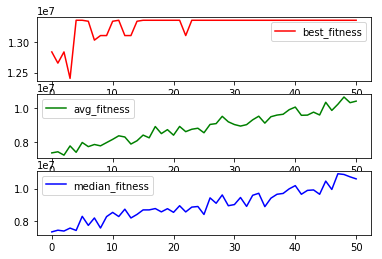

In [15]:
# 执行代码
c = True
while c:
    a = run_QGA()
    if a.first_better_fitness_generation:
        c = False
        a.draw_pictual_2()